In [1]:
import pickle
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from distance_result import DistanceResult
from utils import get_ranked_df_per_perturbation, calc_rank_percentile, get_melted_df_per_perturbation
from utils import get_flat_df, normalize_per_metric, plt_legend

sc.set_figure_params(dpi=100, frameon=False, facecolor=None)

[rank: 0] Global seed set to 0


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

To use sccoda or tasccoda please install ete3 with pip install ete3

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dss_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj'

In [48]:
%%time
with open(f'{dss_path}/spK562_sub.pkl', 'rb') as file:  # metric_runs_sciplex.pkl
    results = pickle.load(file)
print(results.keys())

dict_keys(['1000-lognorm-n_genes', '2000-lognorm-n_genes'])
CPU times: user 109 ms, sys: 6.36 s, total: 6.46 s
Wall time: 8.9 s


In [49]:
metrics = list(results.values())[0].metrics
metrics

['kl_divergence',
 'euclidean',
 't_test',
 'spearman_distance',
 'wasserstein',
 'pearson_distance',
 'edistance',
 'r2_distance',
 'cosine_distance',
 'mmd',
 'mean_absolute_error',
 'mse']

In [50]:
controls = ['control0', 'control1', 'control2', 'control3', 'control4']

In [54]:
# %load plotting_util.py
def plot(tags, plot=True):
    label_tag = tags[0]
    
    pwdfs = {}
    for k, res in results.items():
        if all(t in k for t in tags):
            pwdfs.update(res.pwdfs)
    
    if len(pwdfs) < 2:
        raise ValueError(f'Conditions {tags} were not run.')

    individually_ranked = get_ranked_df_per_perturbation(pwdfs, metrics, controls, label_tag)
    ctrl_ranks = calc_rank_percentile(individually_ranked, controls)

    if plot:
        melted_df = get_flat_df(pwdfs, controls, label=label_tag)
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=normalize_per_metric(melted_df), x=label_tag, y='avg_dist', hue='metric')
        plt.ylabel('relative avg dist');
        if 'n_genes' in label_tag:
            plt.xscale('log')
        plt_legend()
        plt.title(f'distance behavior w.r.t {label_tag} in {tags[1]} space')
        plt.show()

        ctrl_ranks[label_tag] = ctrl_ranks[label_tag].astype(float)
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=ctrl_ranks, x=label_tag, y='rank', hue='metric')
        plt.ylabel('control rank percentile')
        plt.ylim(-.05, 1)
        if 'n_genes' in label_tag:
            plt.xscale('log')
        plt_legend()
        plt.title(f'sensitivity w.r.t. {label_tag} in {tags[1]} space')
        plt.show()
    
    return pwdfs, ctrl_ranks


## n_cells

In [55]:
pwdfs, _ = plot(['n_cells', 'lognorm'])

ValueError: Conditions ['n_cells', 'lognorm'] were not run.

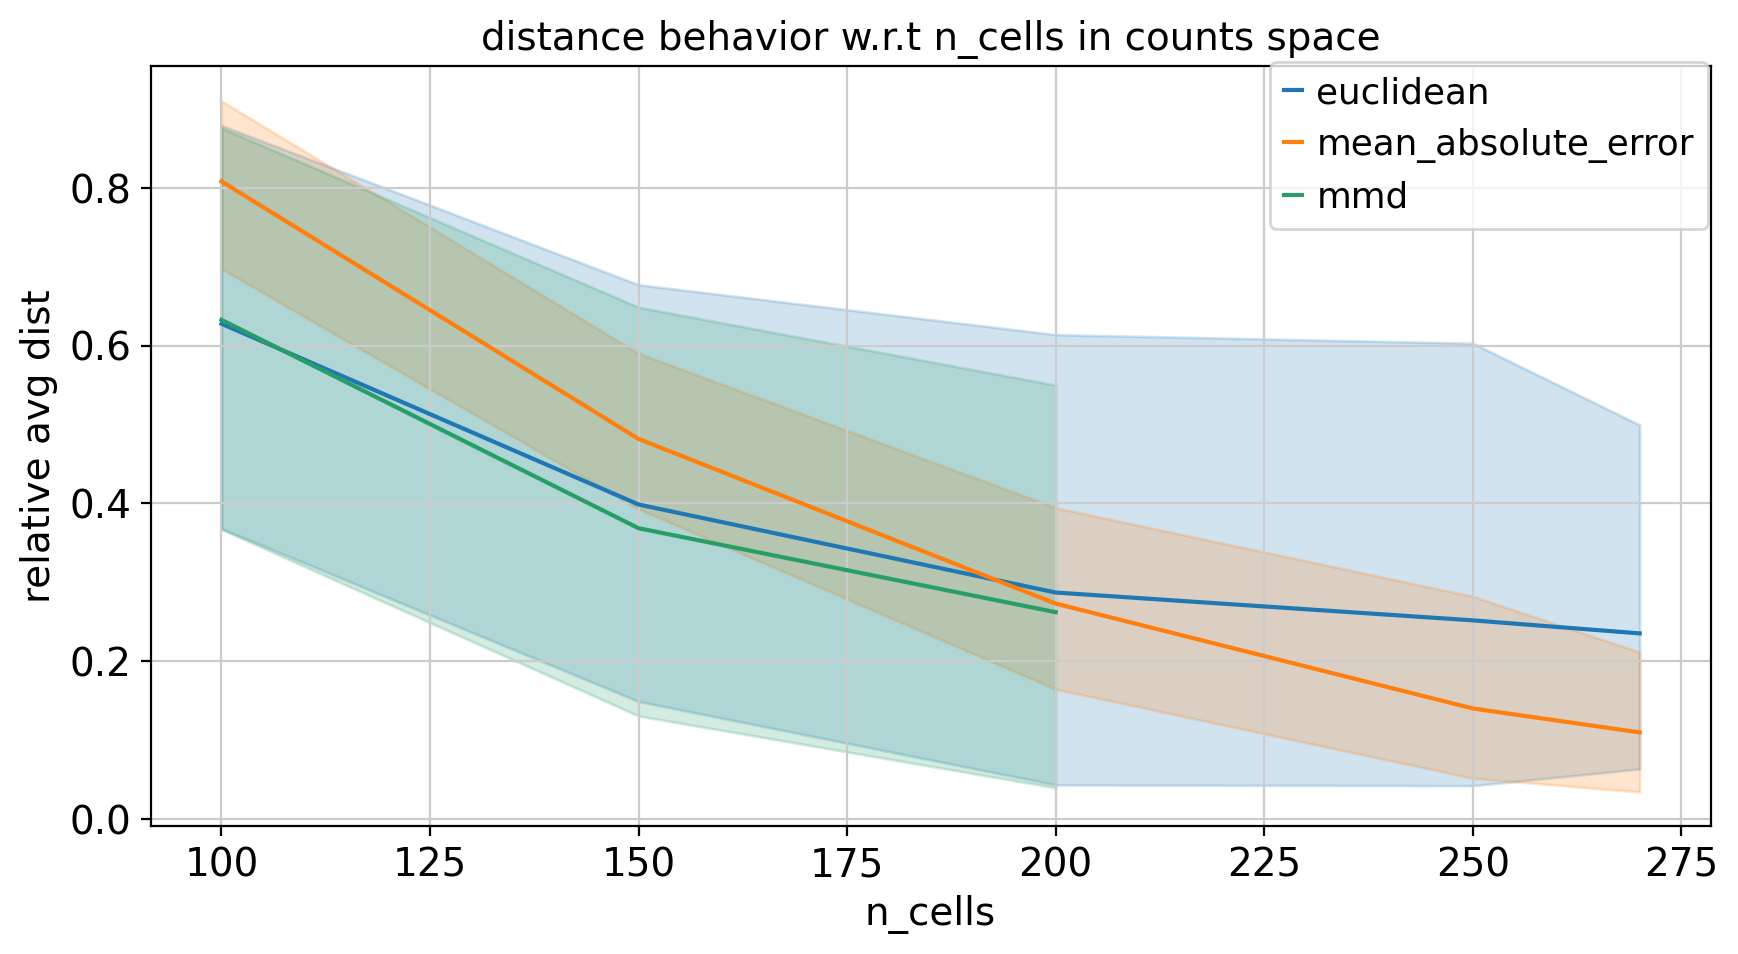

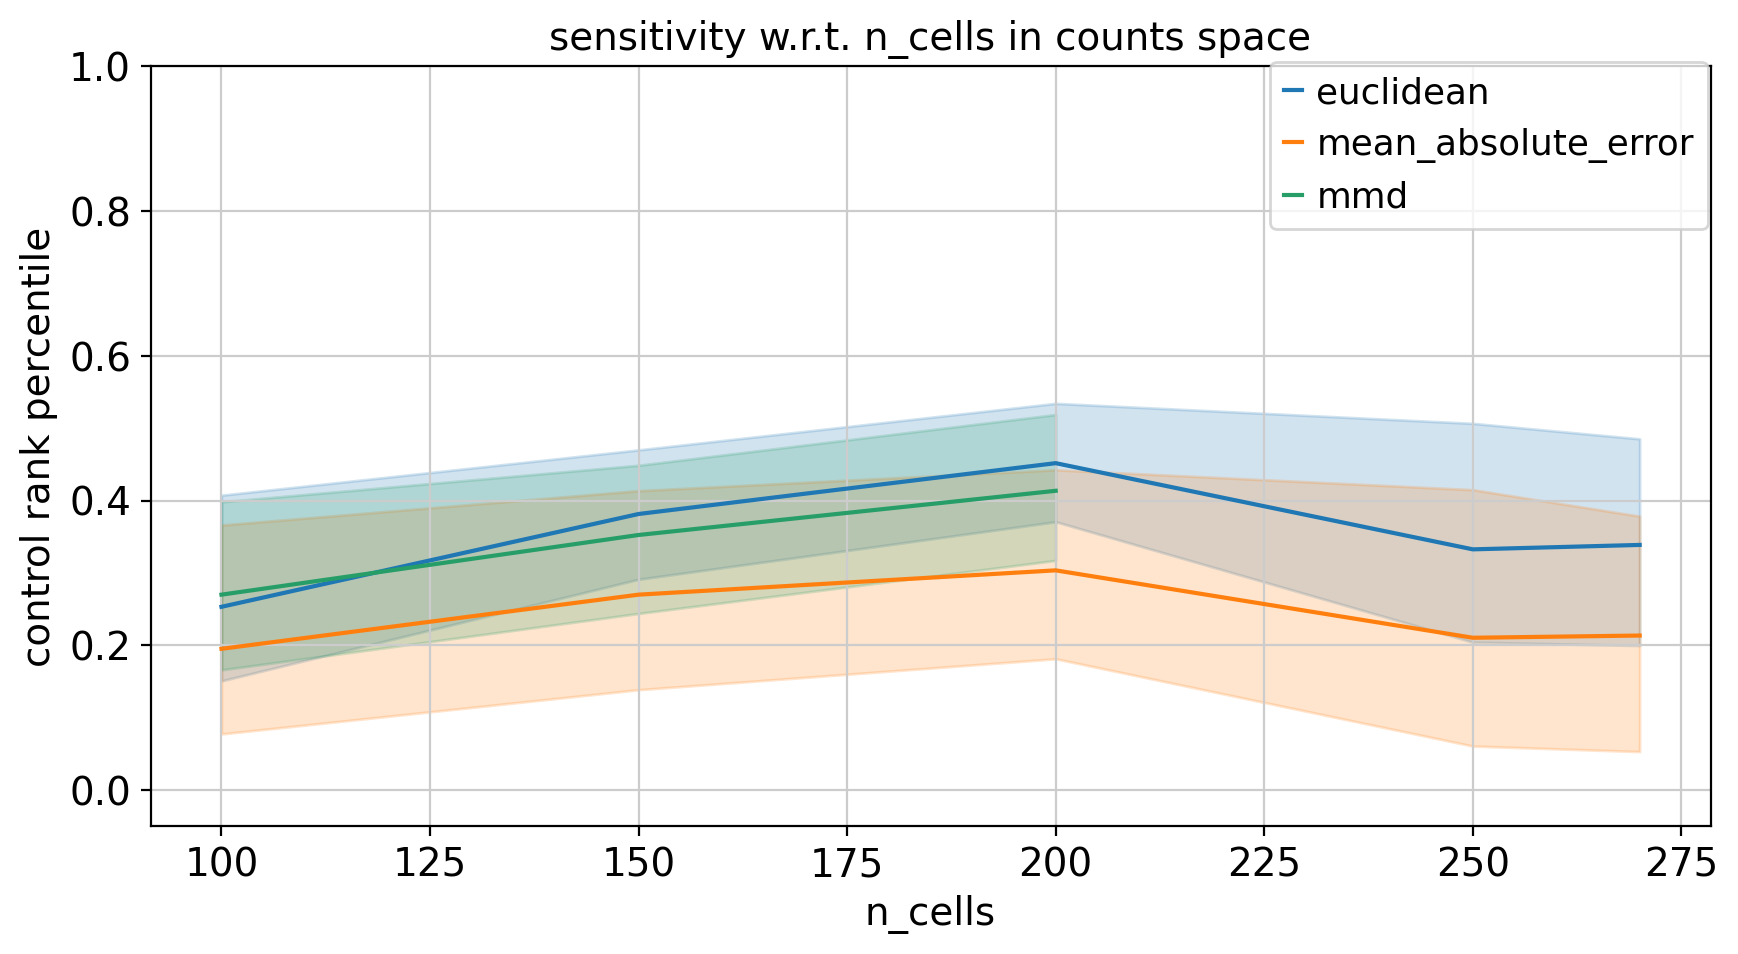

In [34]:
pwdfs, _ = plot(['n_cells', 'counts'])

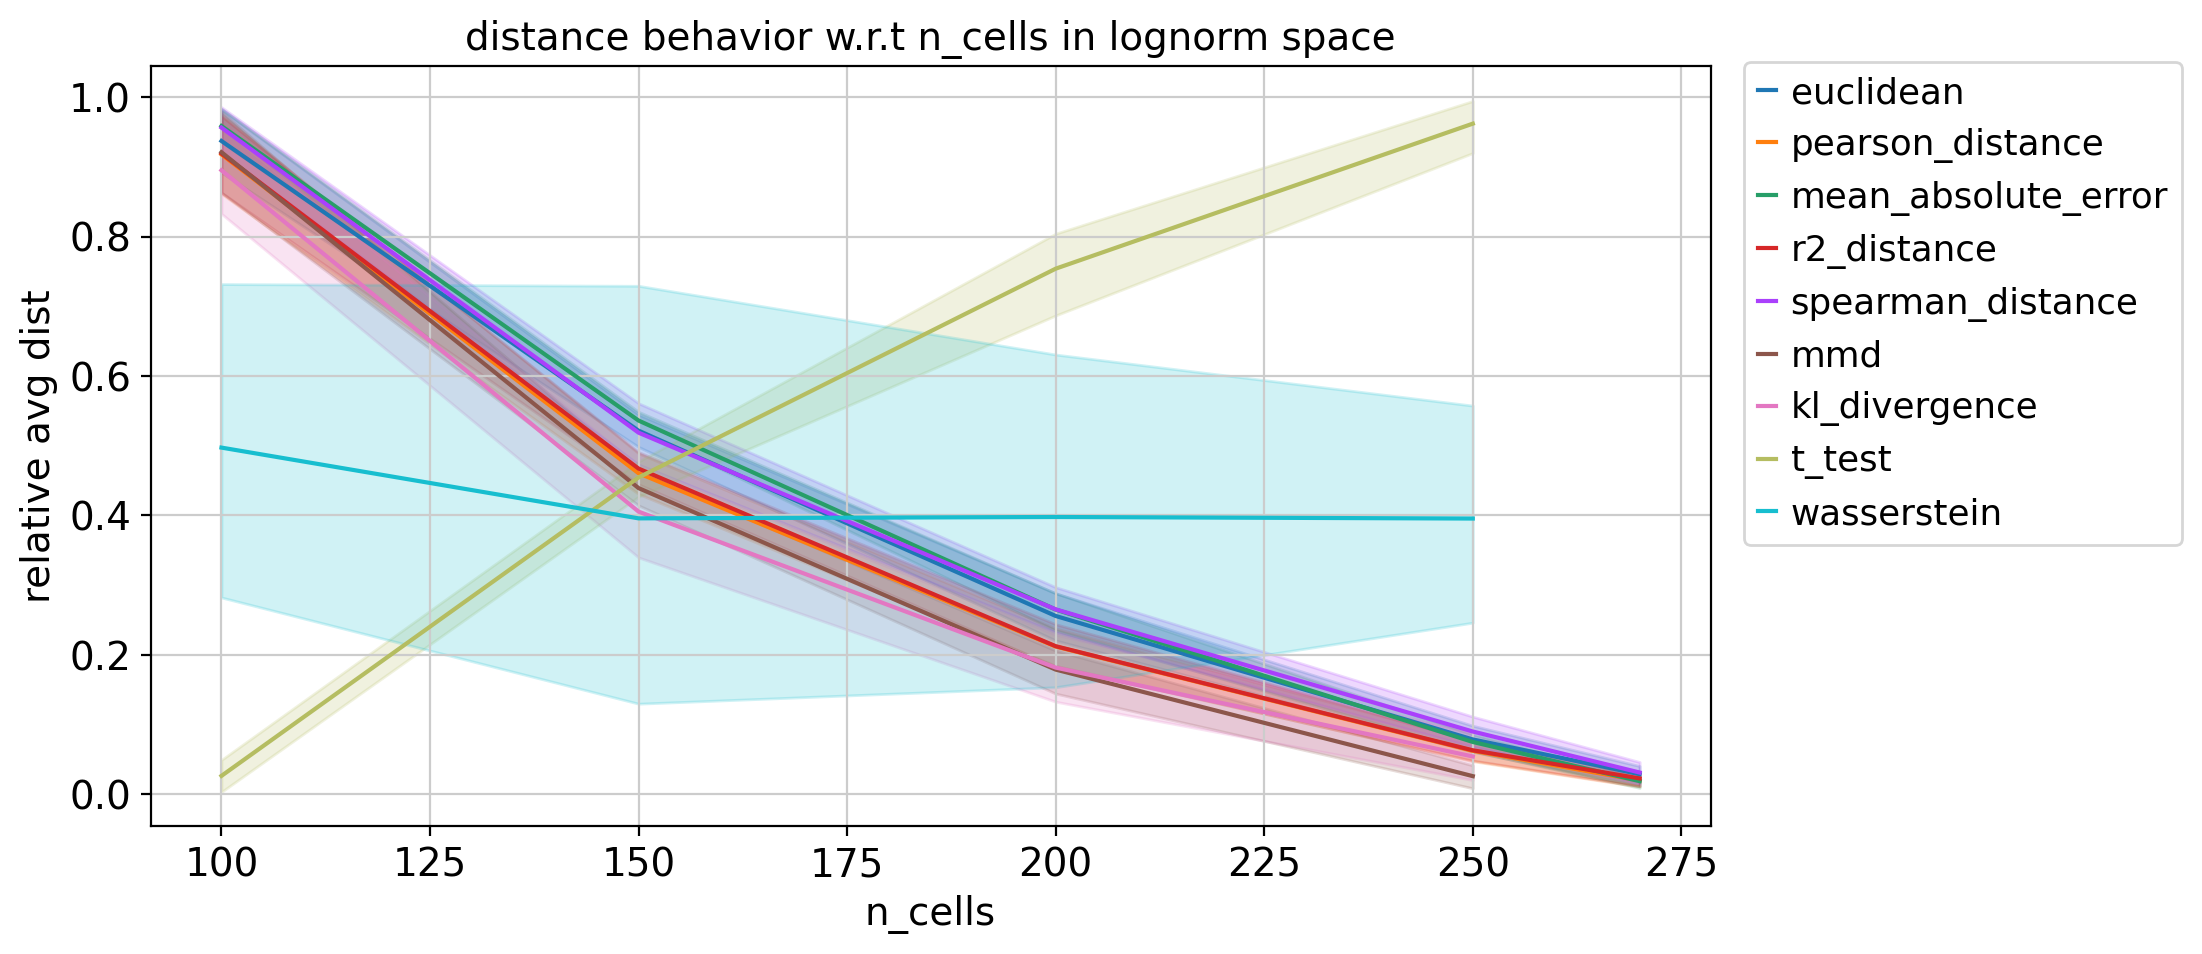

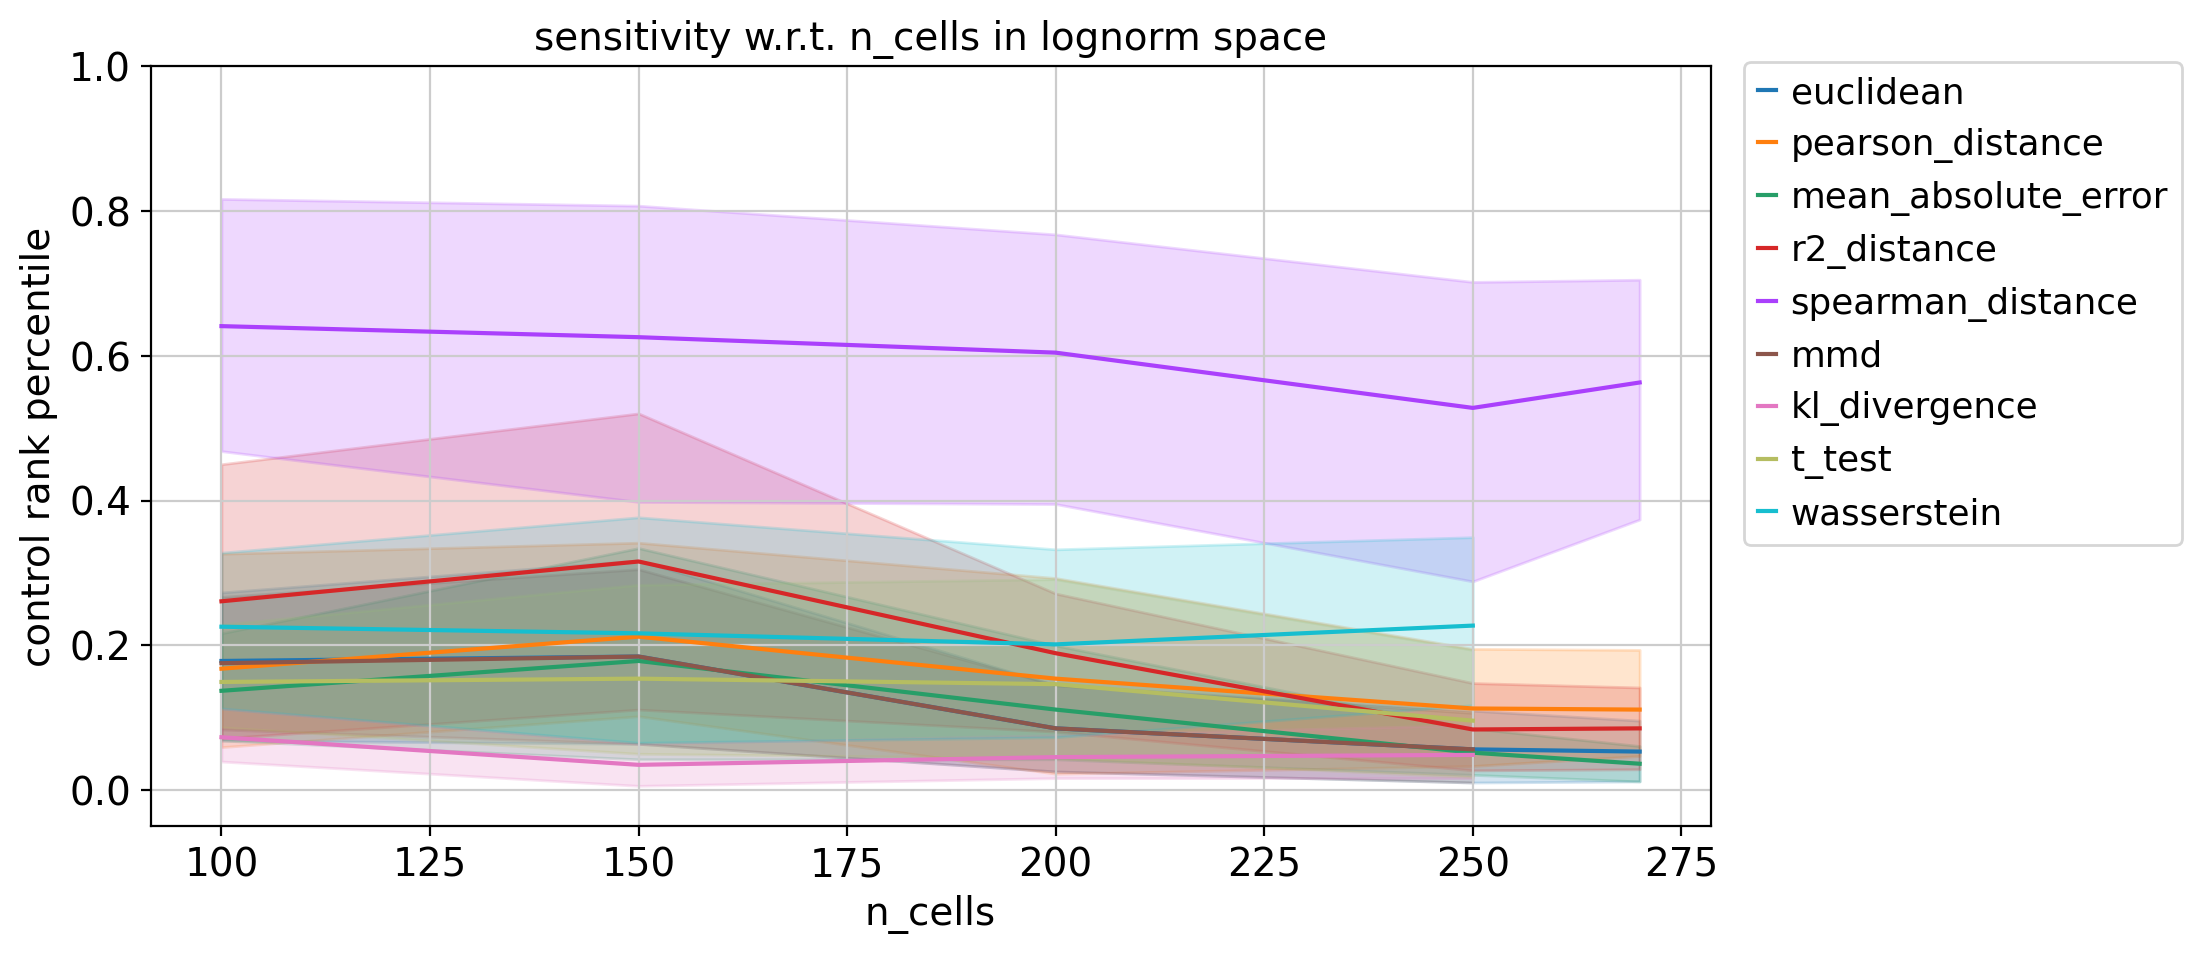

In [14]:
pwdfs = plot(['n_cells', 'lognorm'])

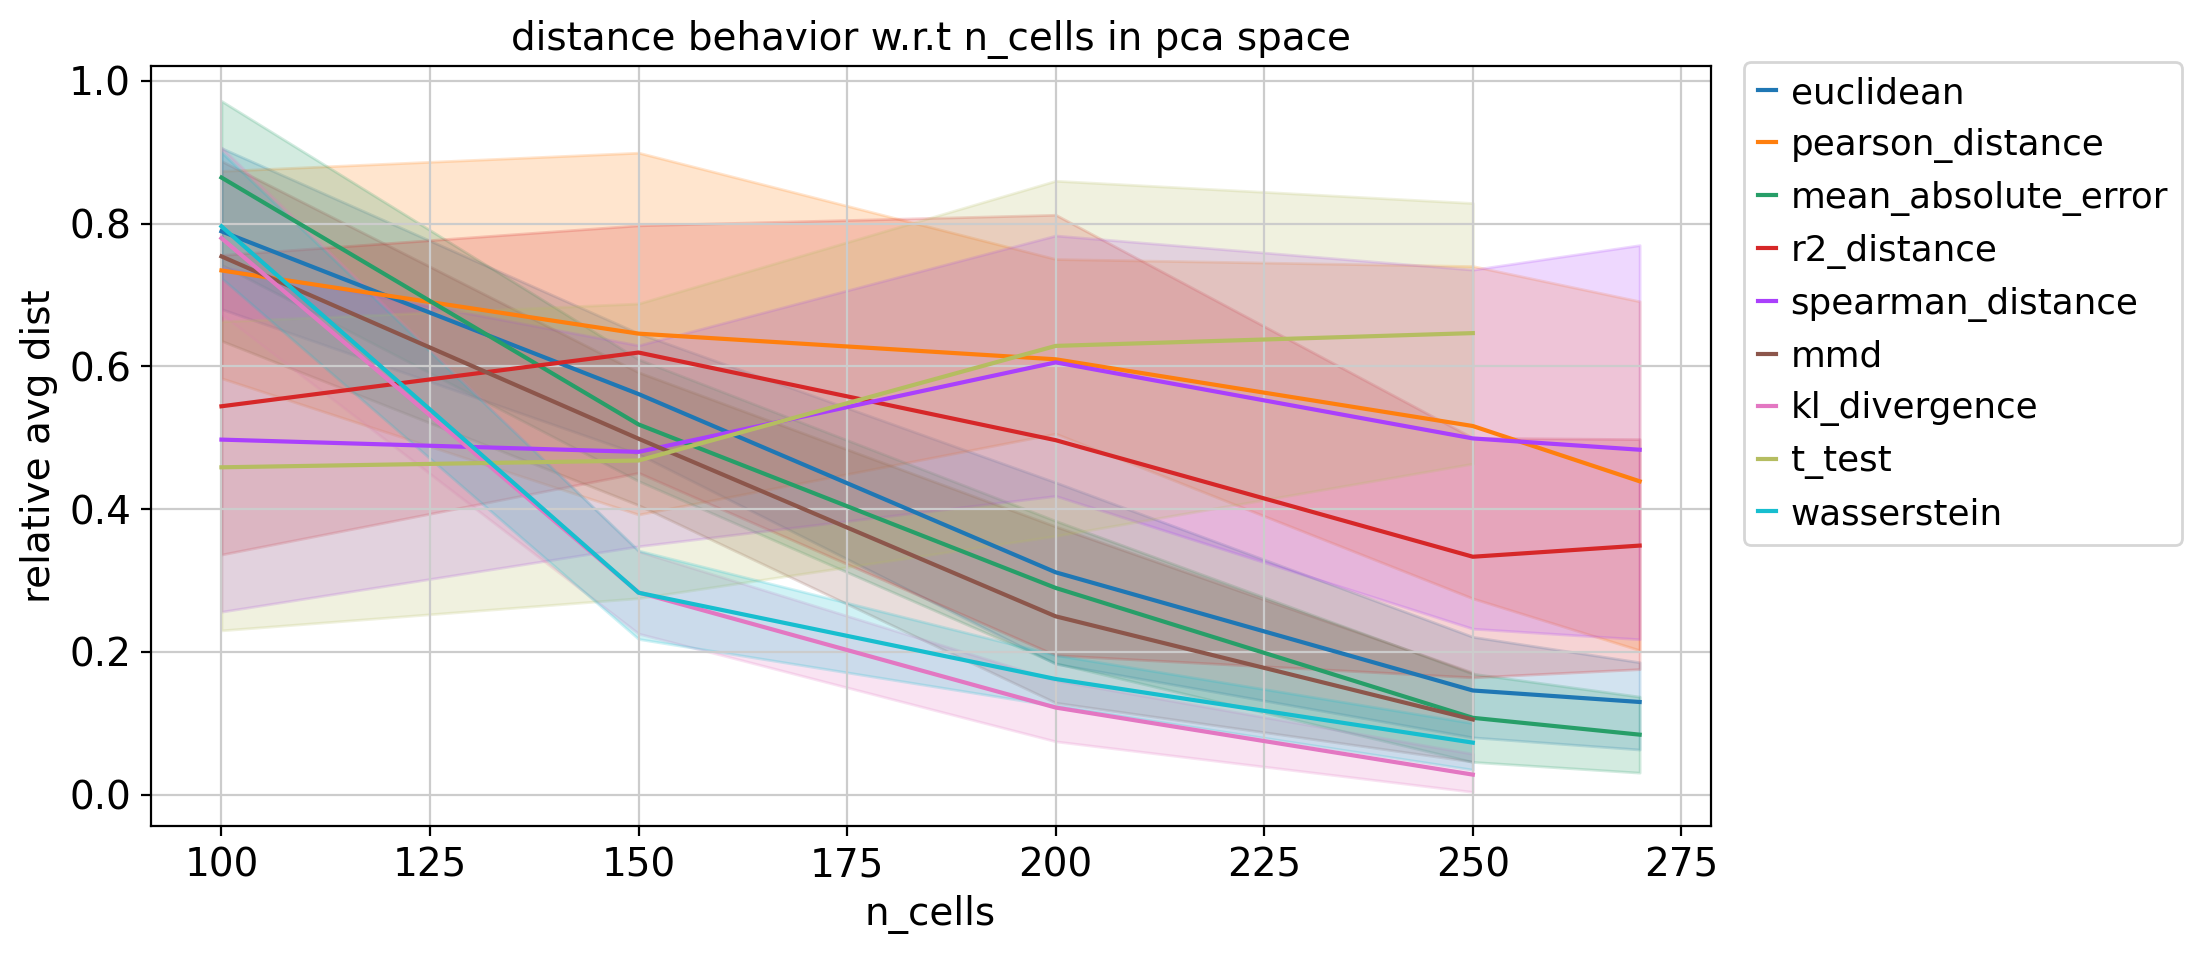

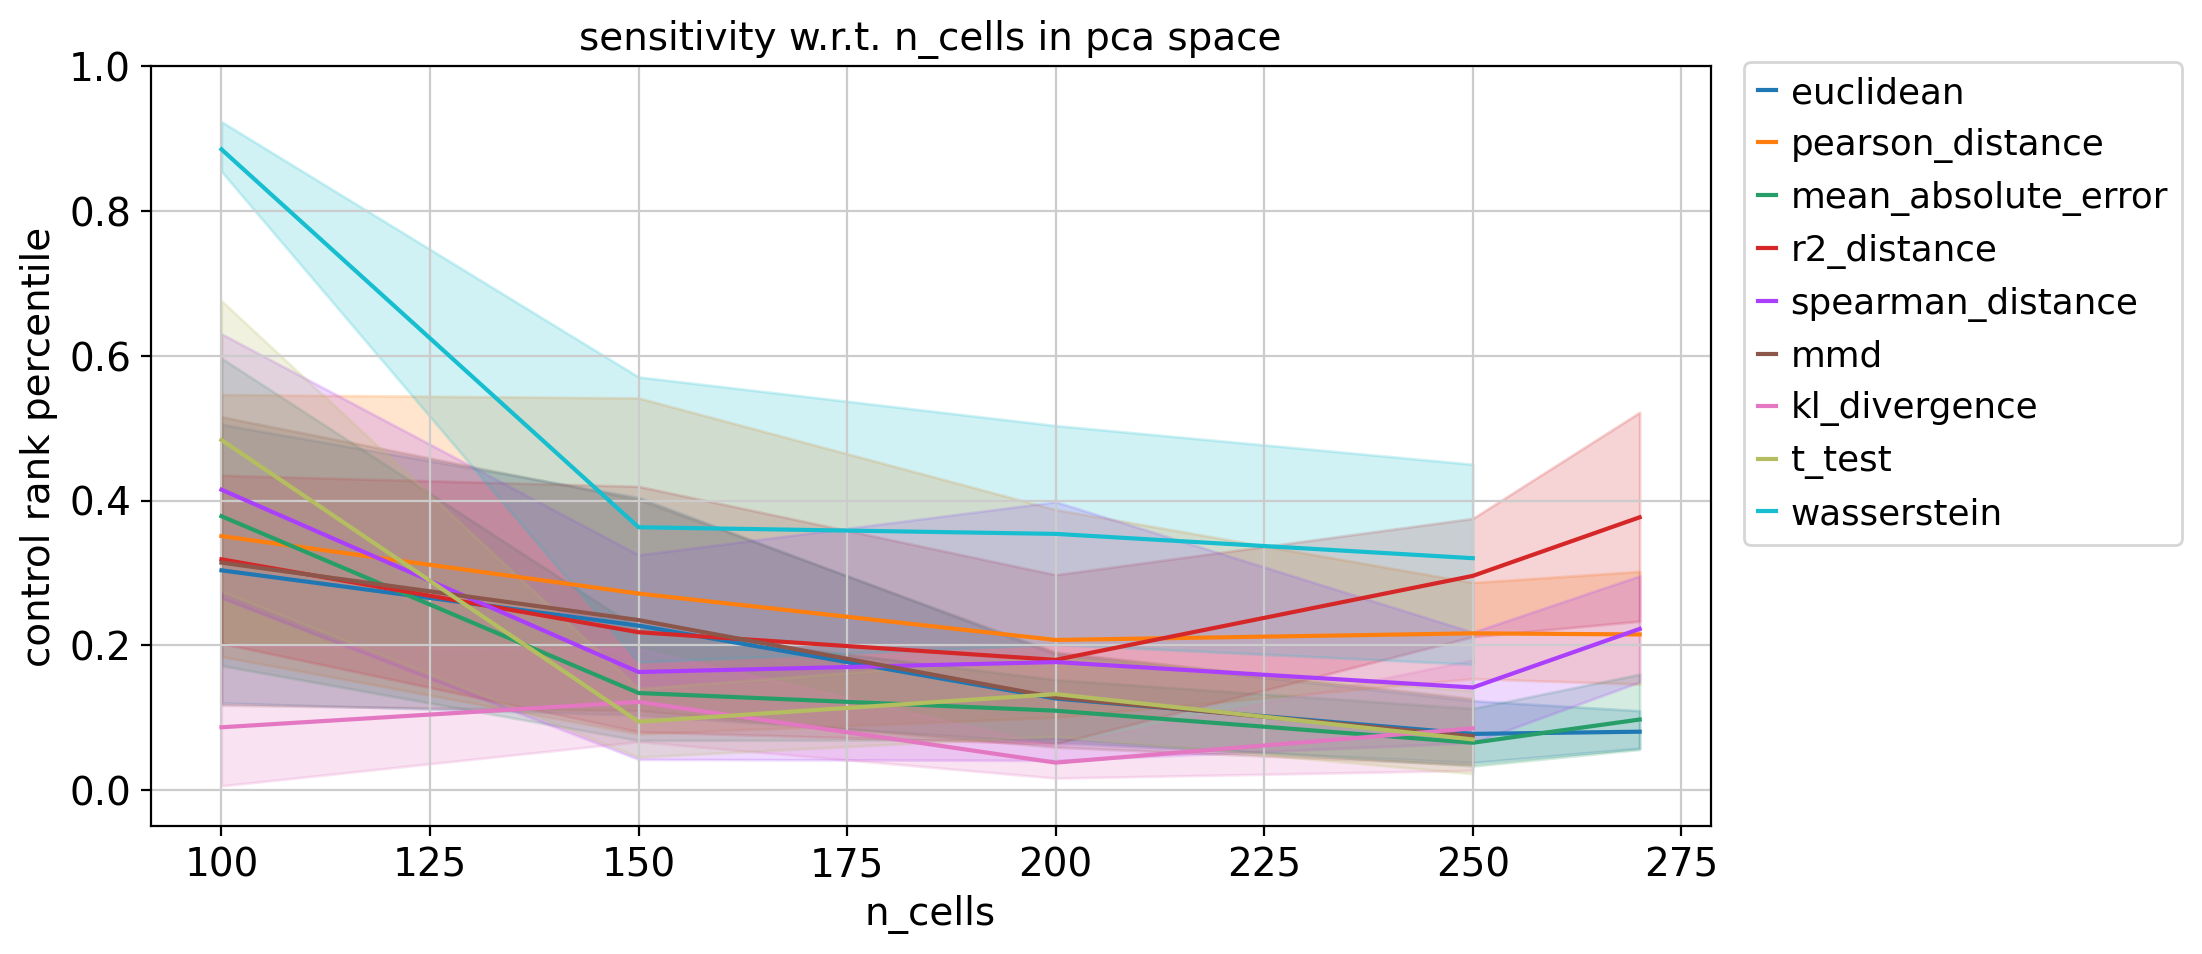

In [15]:
pwdfs = plot(['n_cells', 'pca'])

## n HVGs

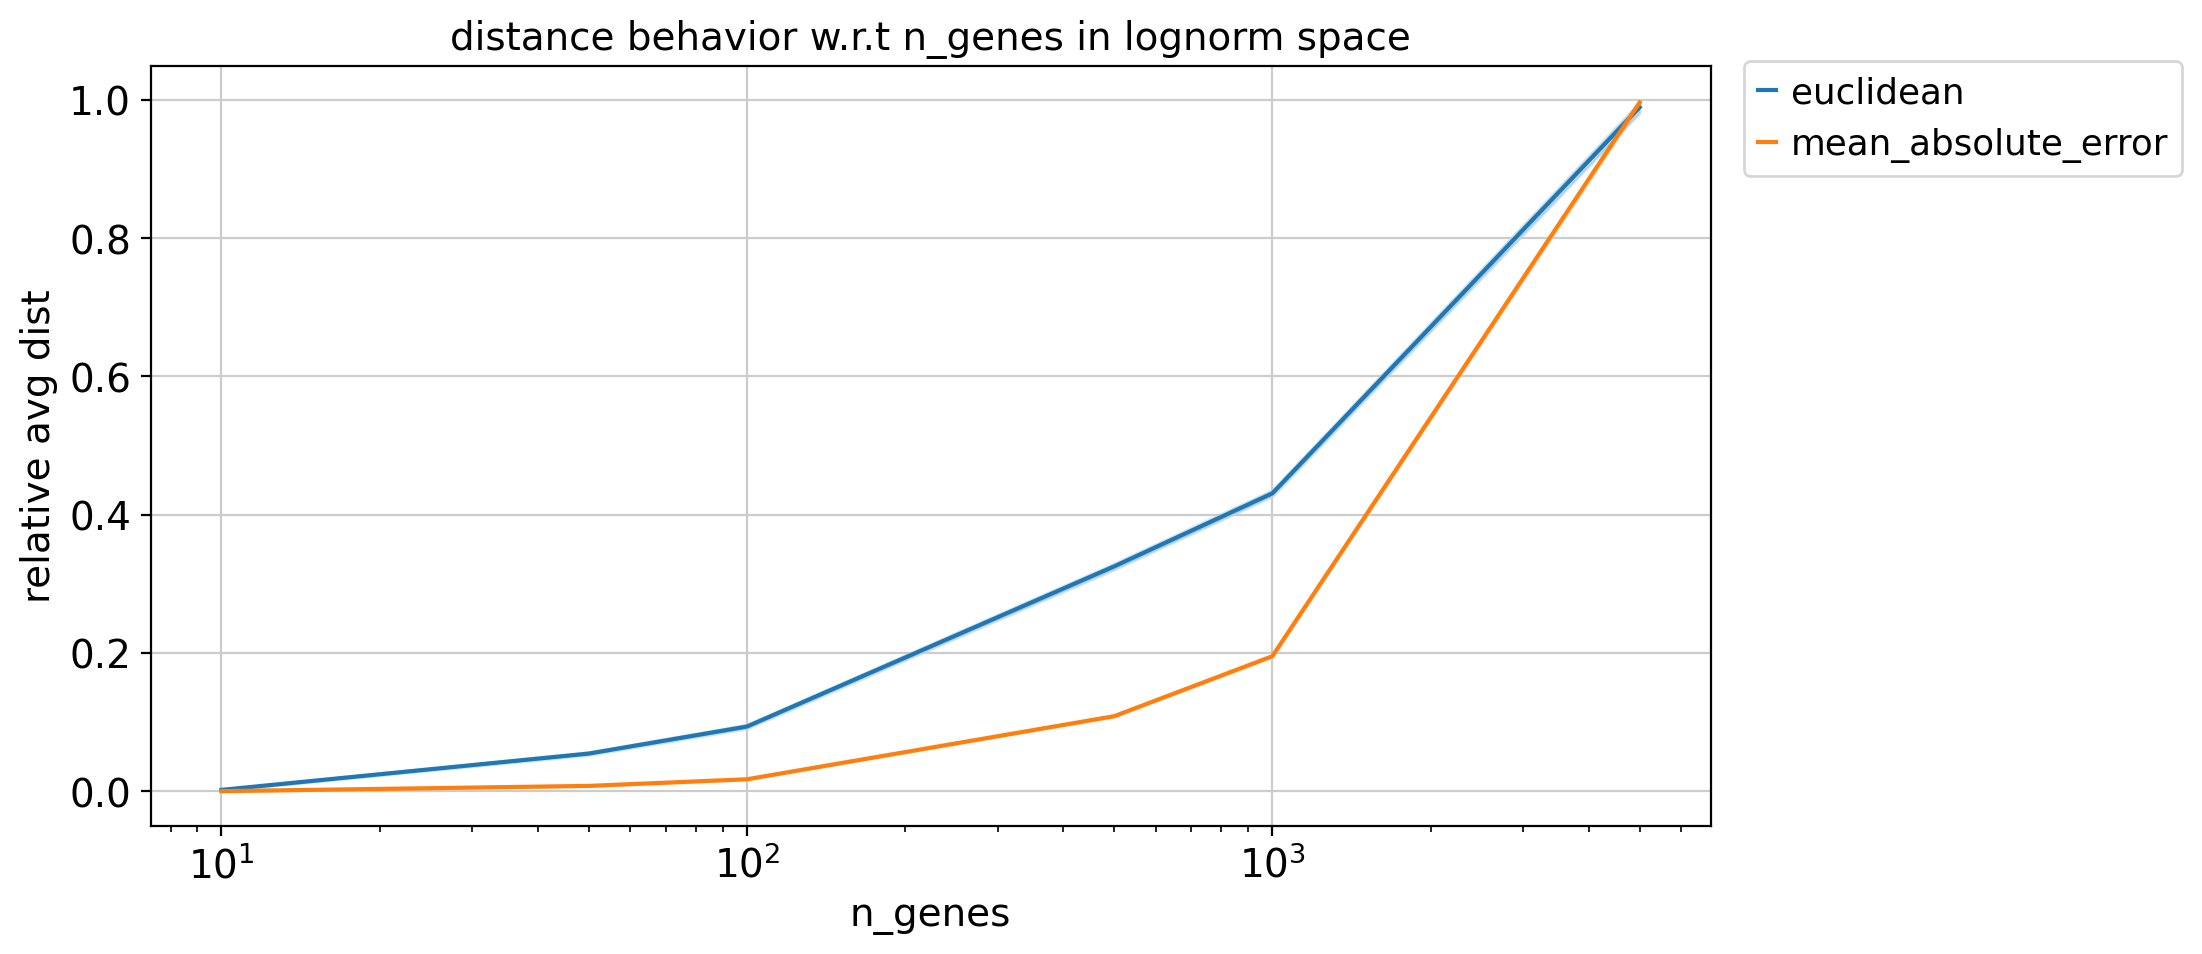

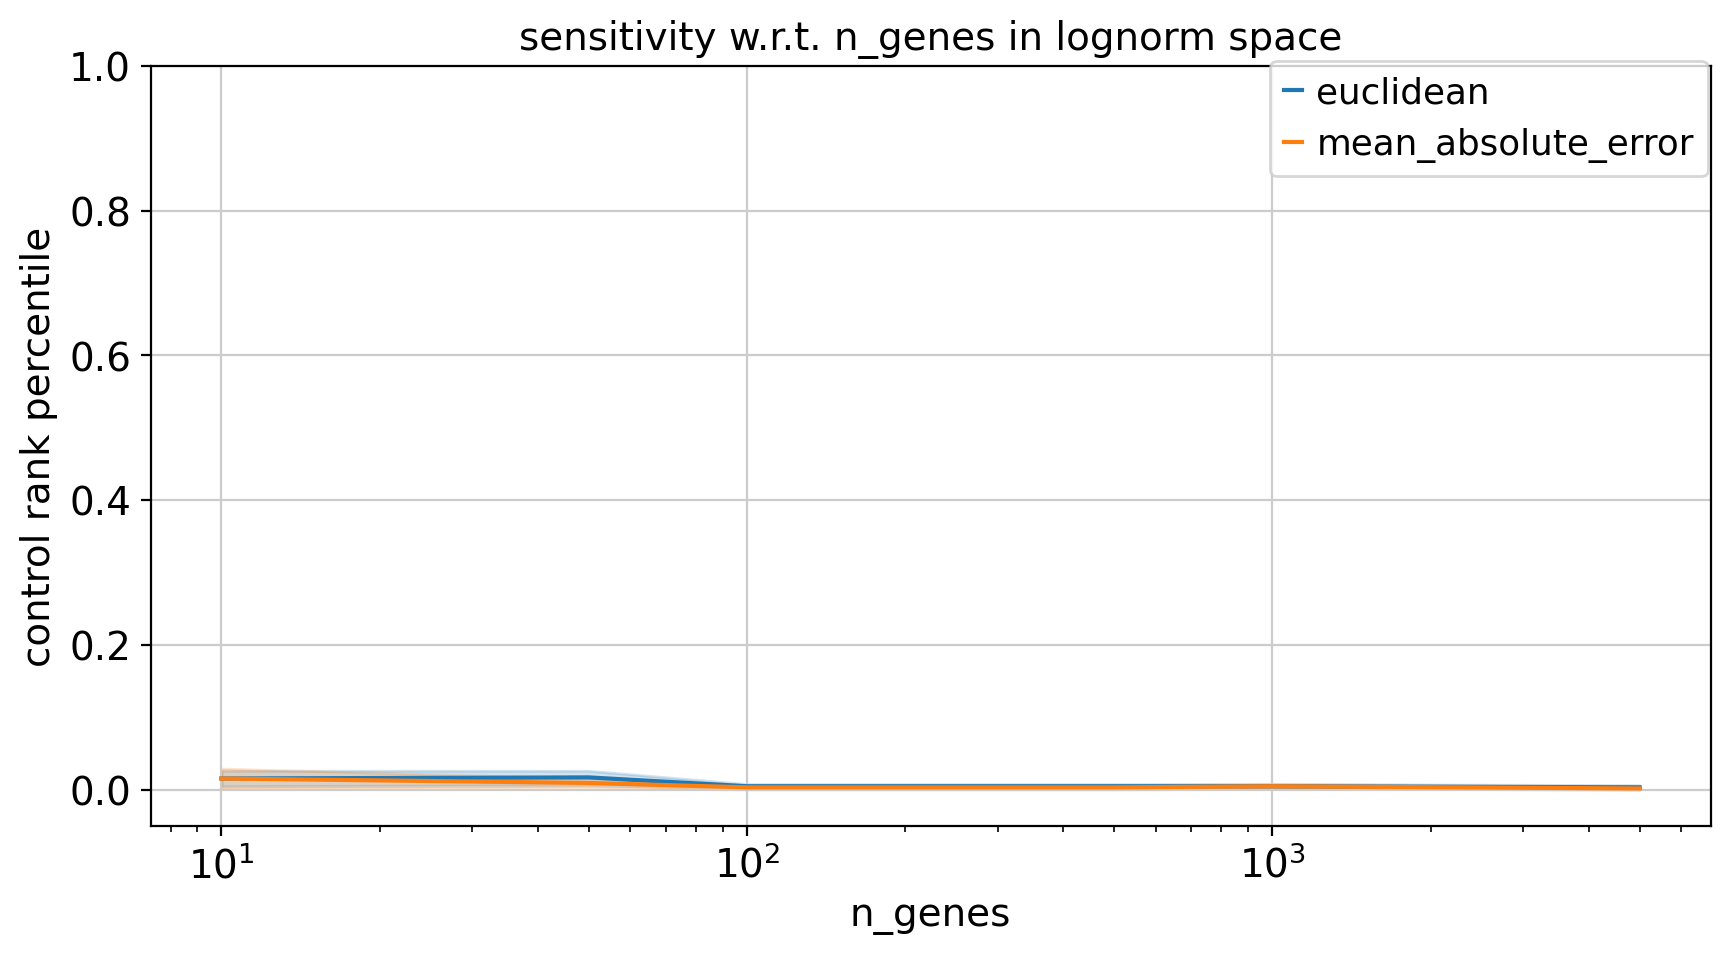

In [35]:
pwdfs, ctrl_ranks = plot(['n_genes', 'lognorm'])

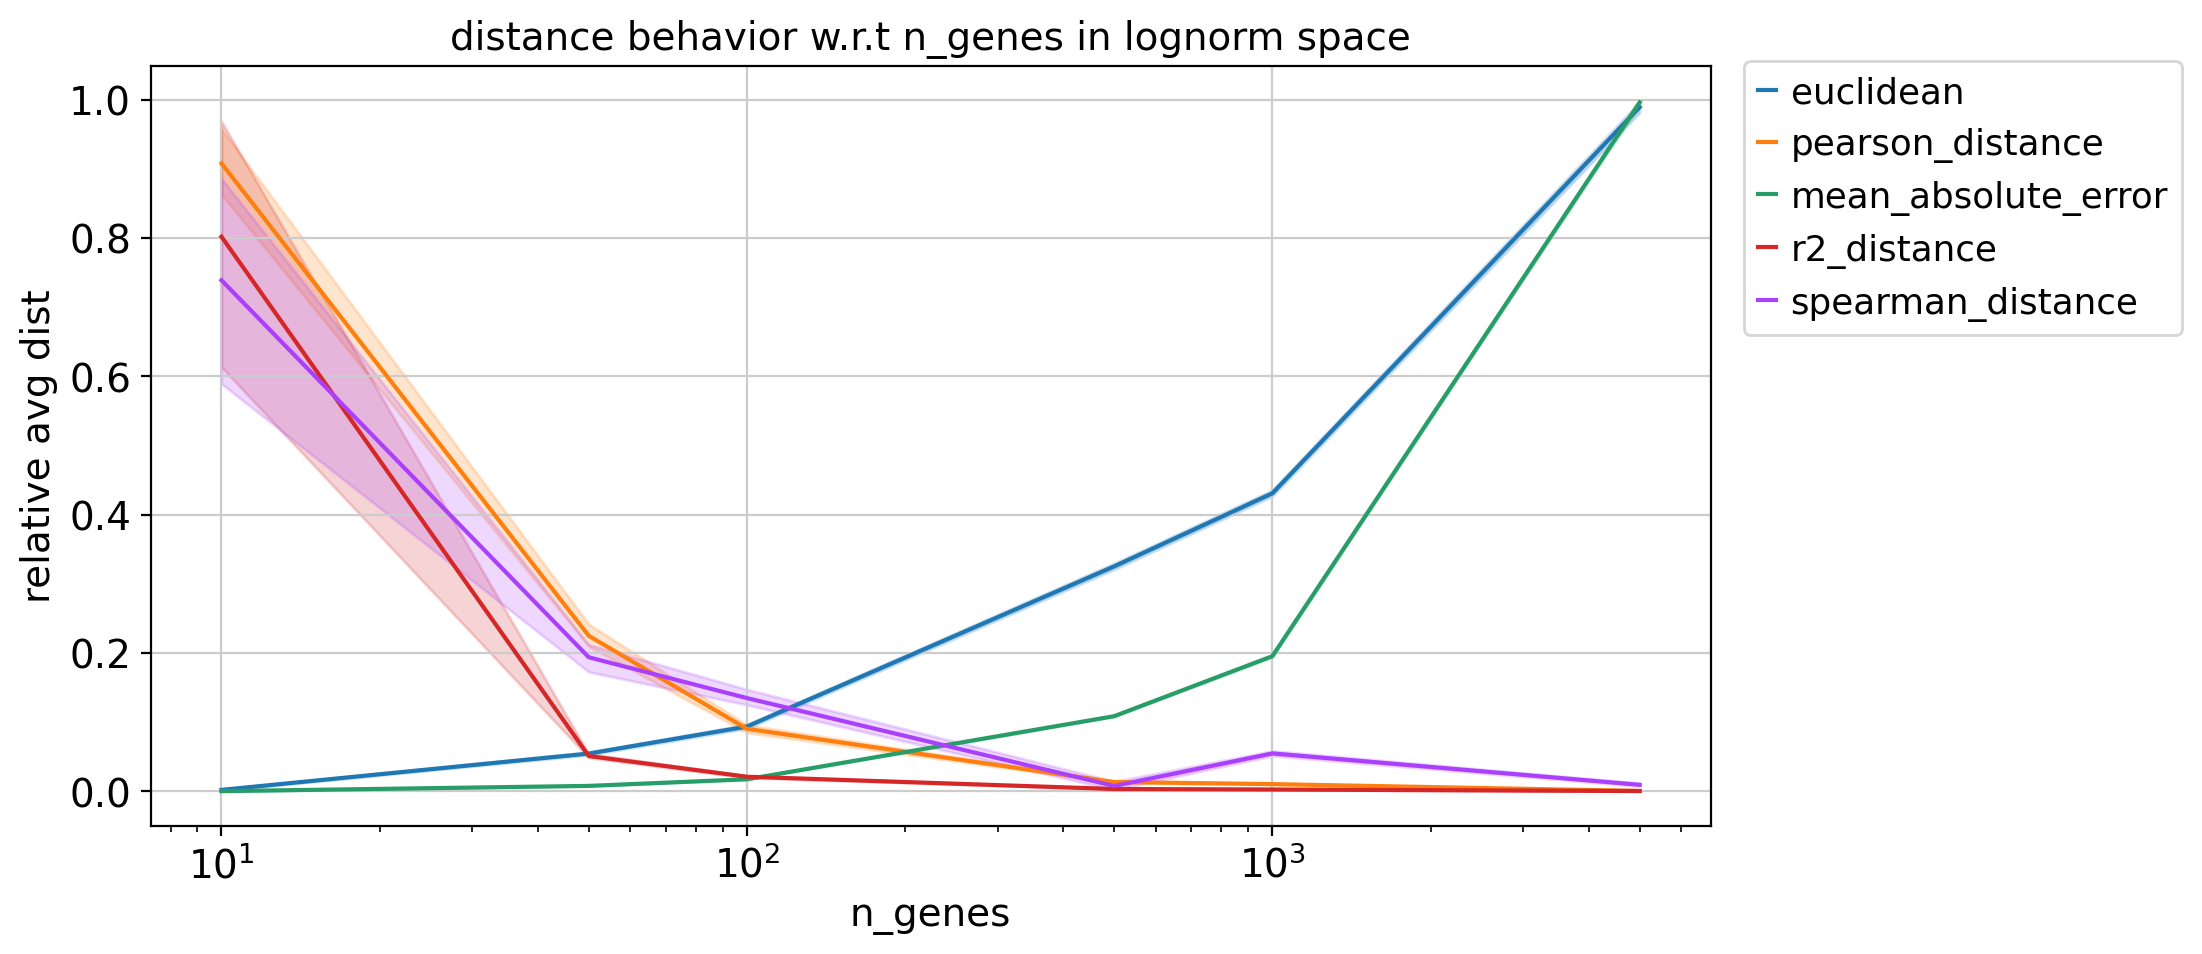

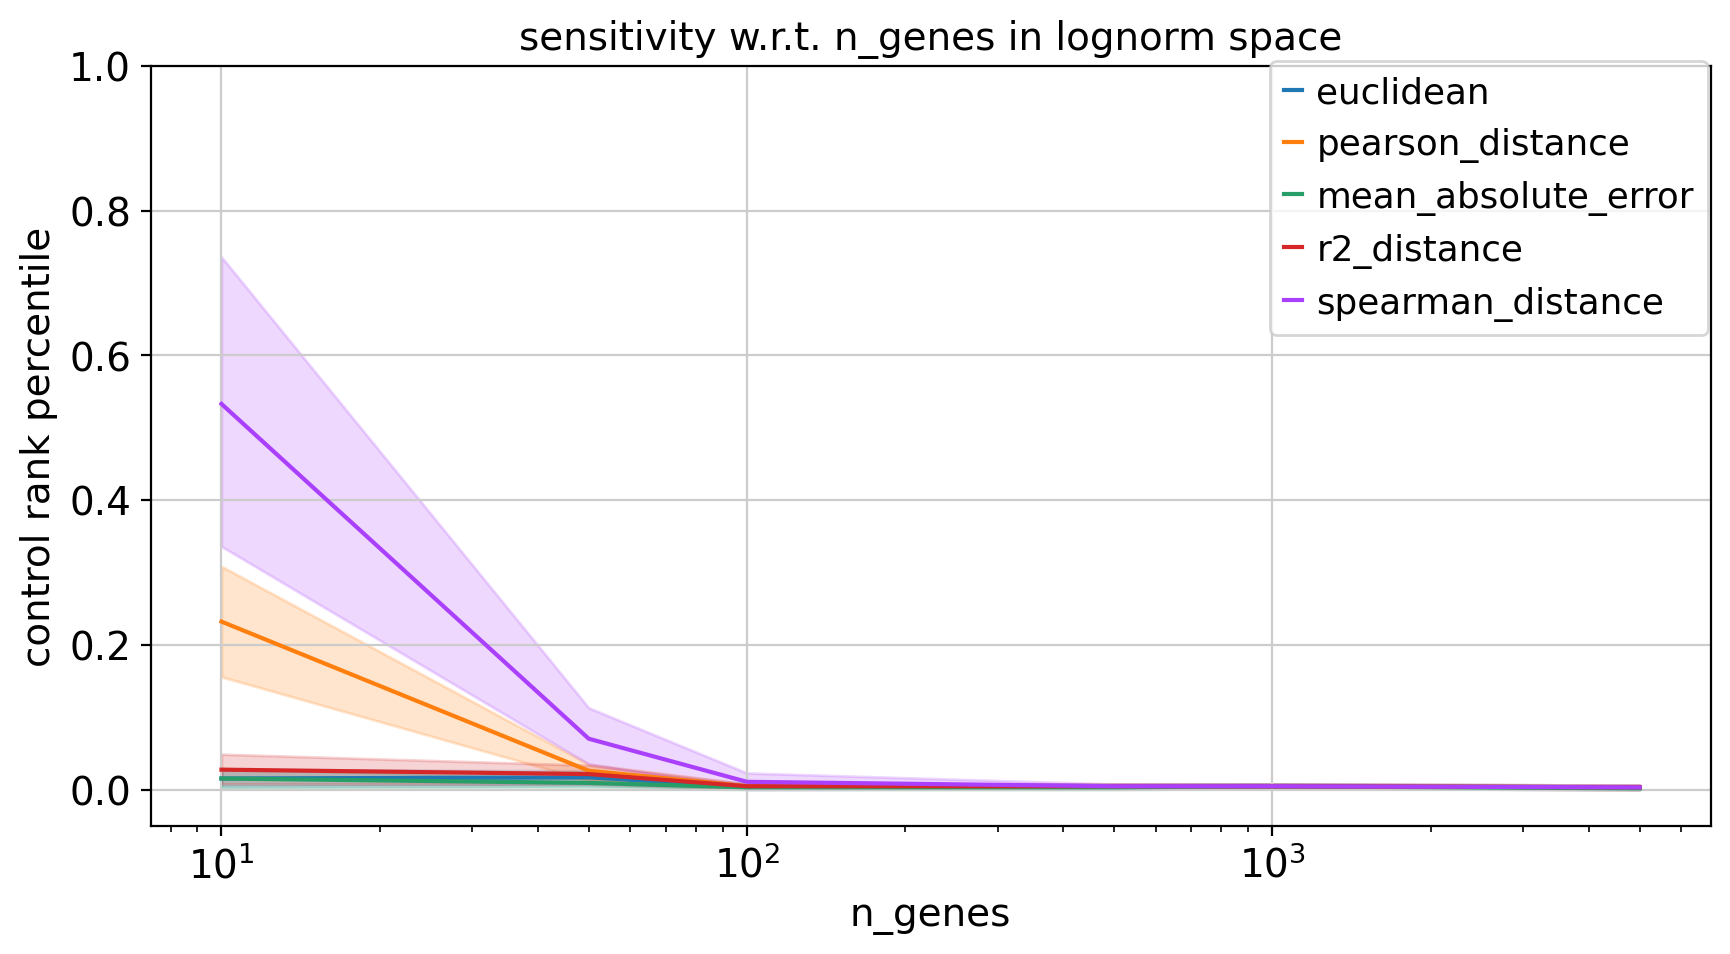

In [17]:
pwdfs, ctrl_ranks = plot(['n_genes', 'lognorm'])

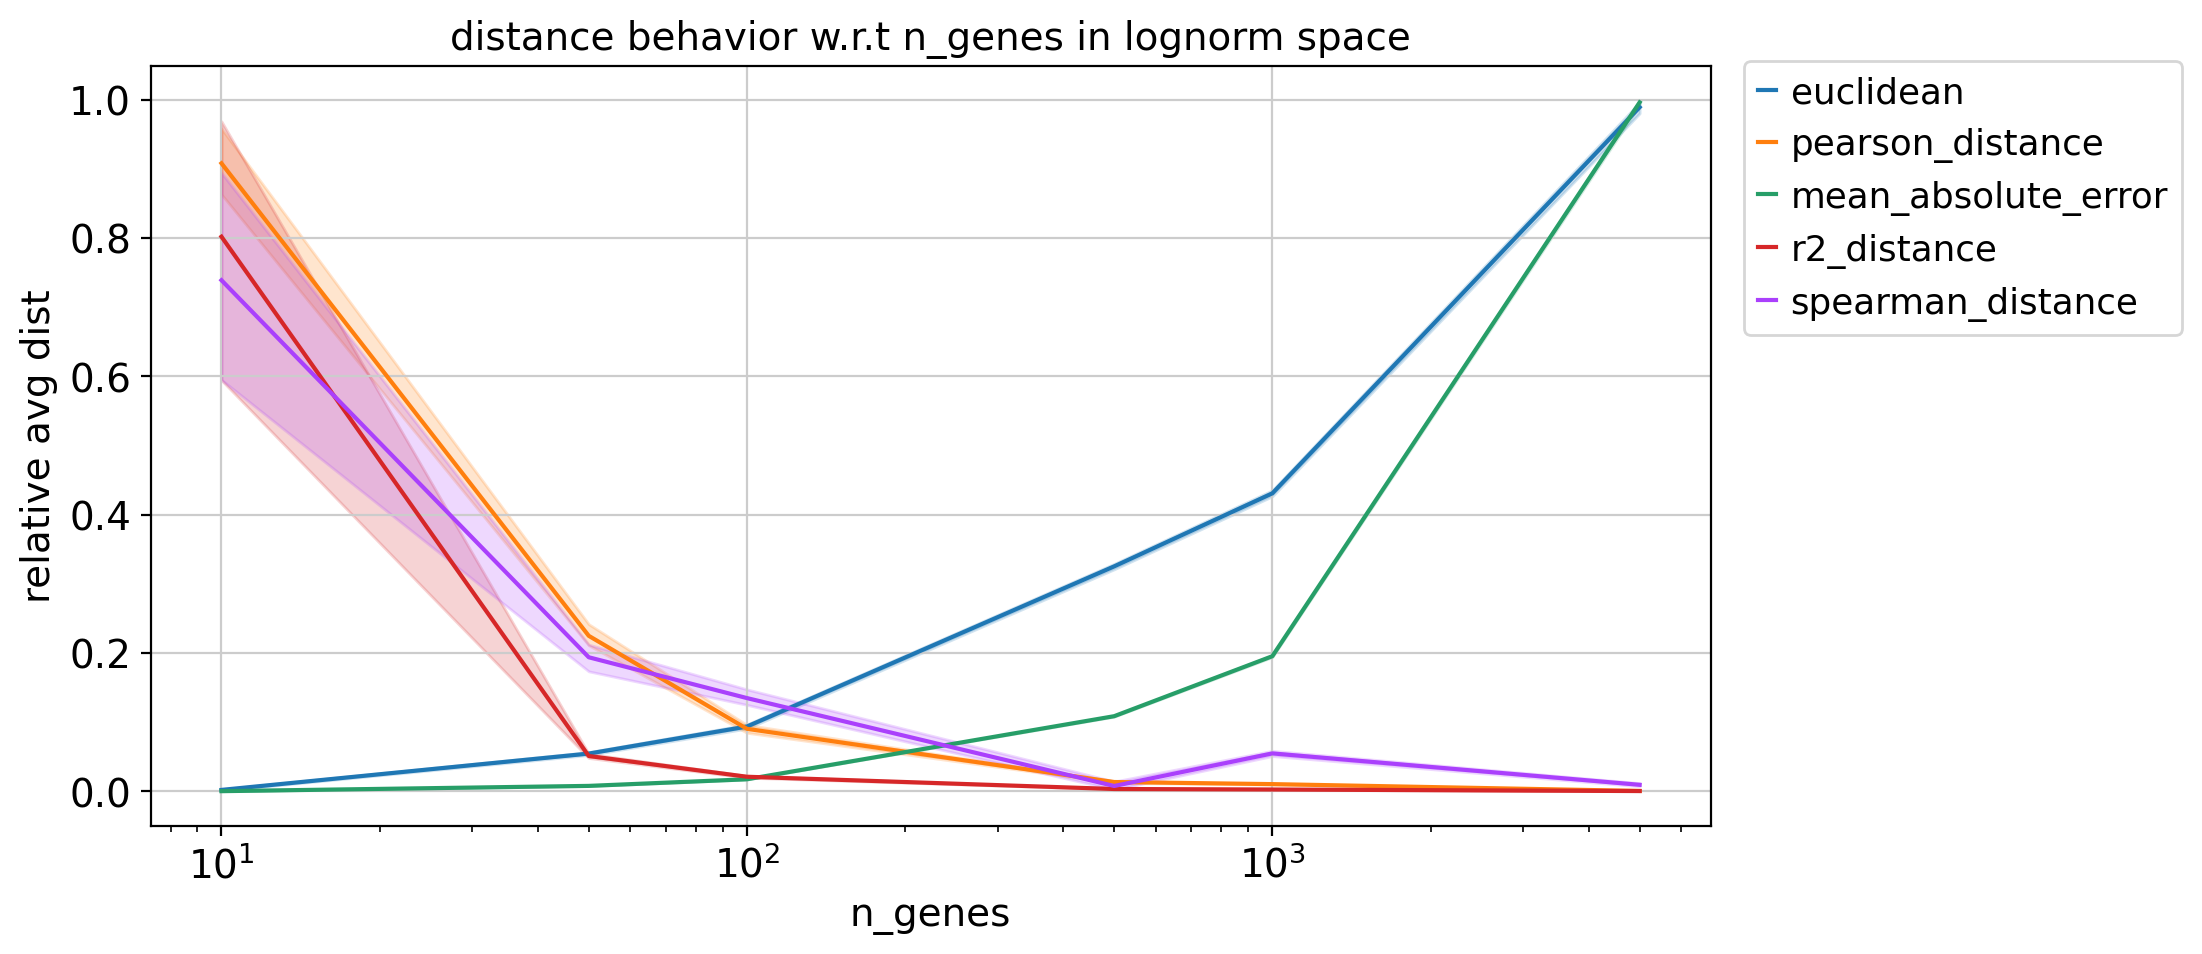

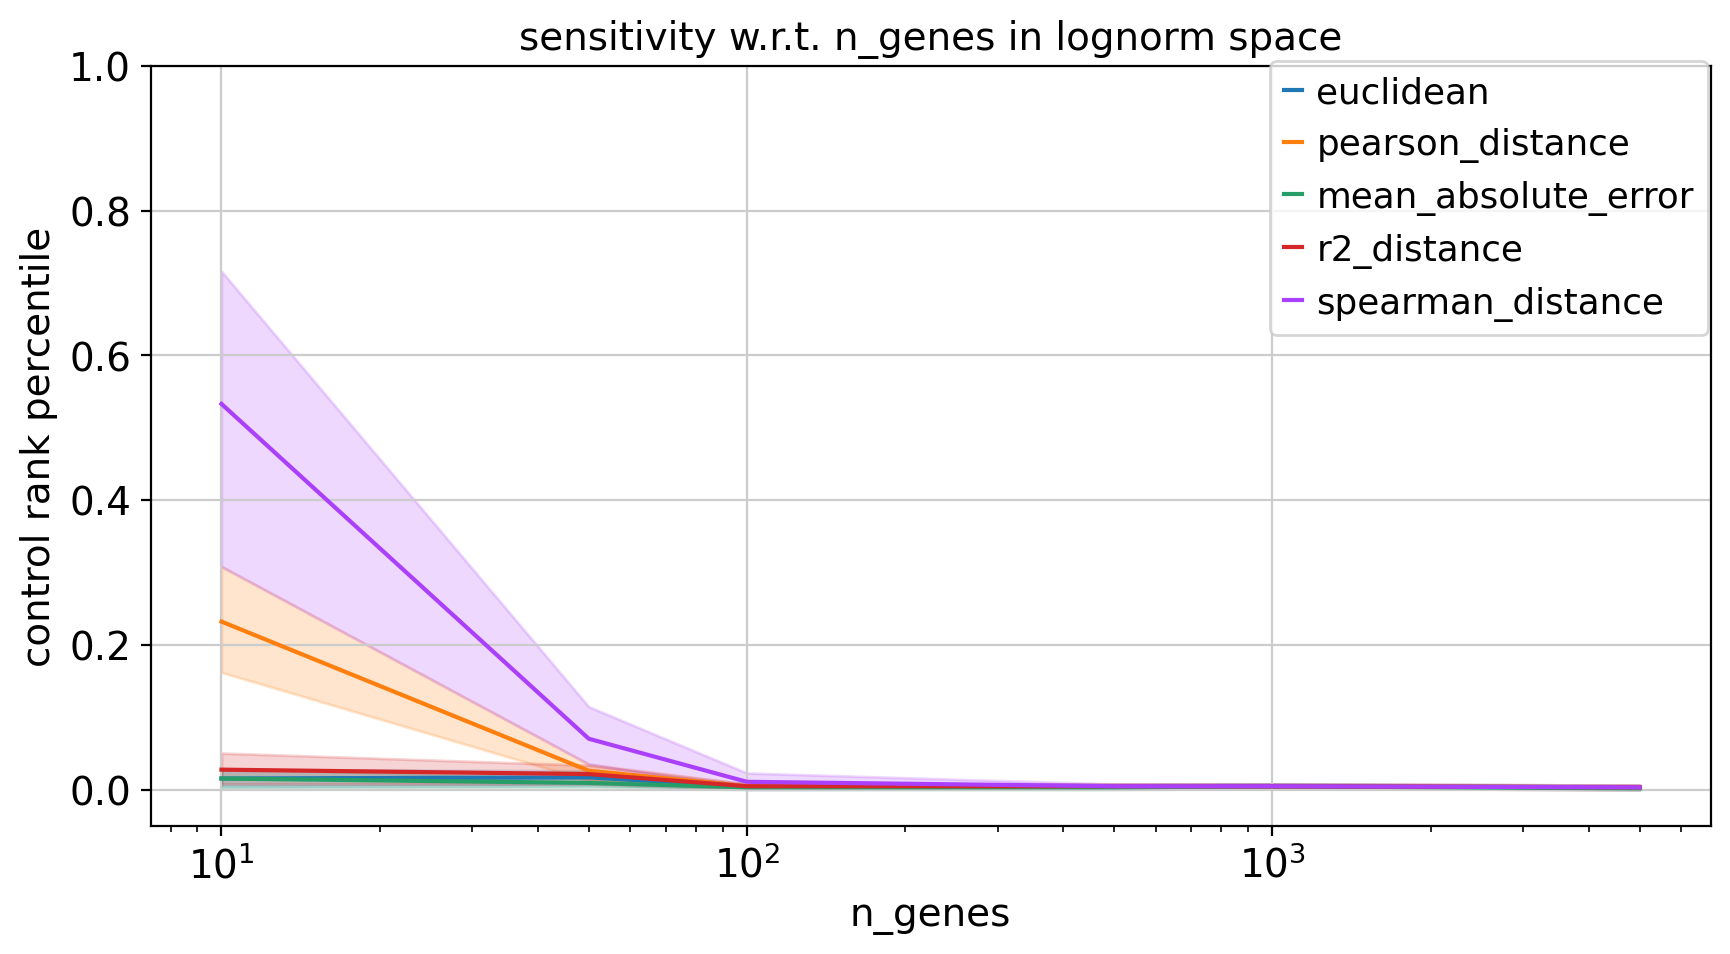

In [38]:
pwdfs = plot(['n_genes', 'lognorm'])

200 HVGs are enough to distinguish control from perturbed.

## n DEGs

## sparsity

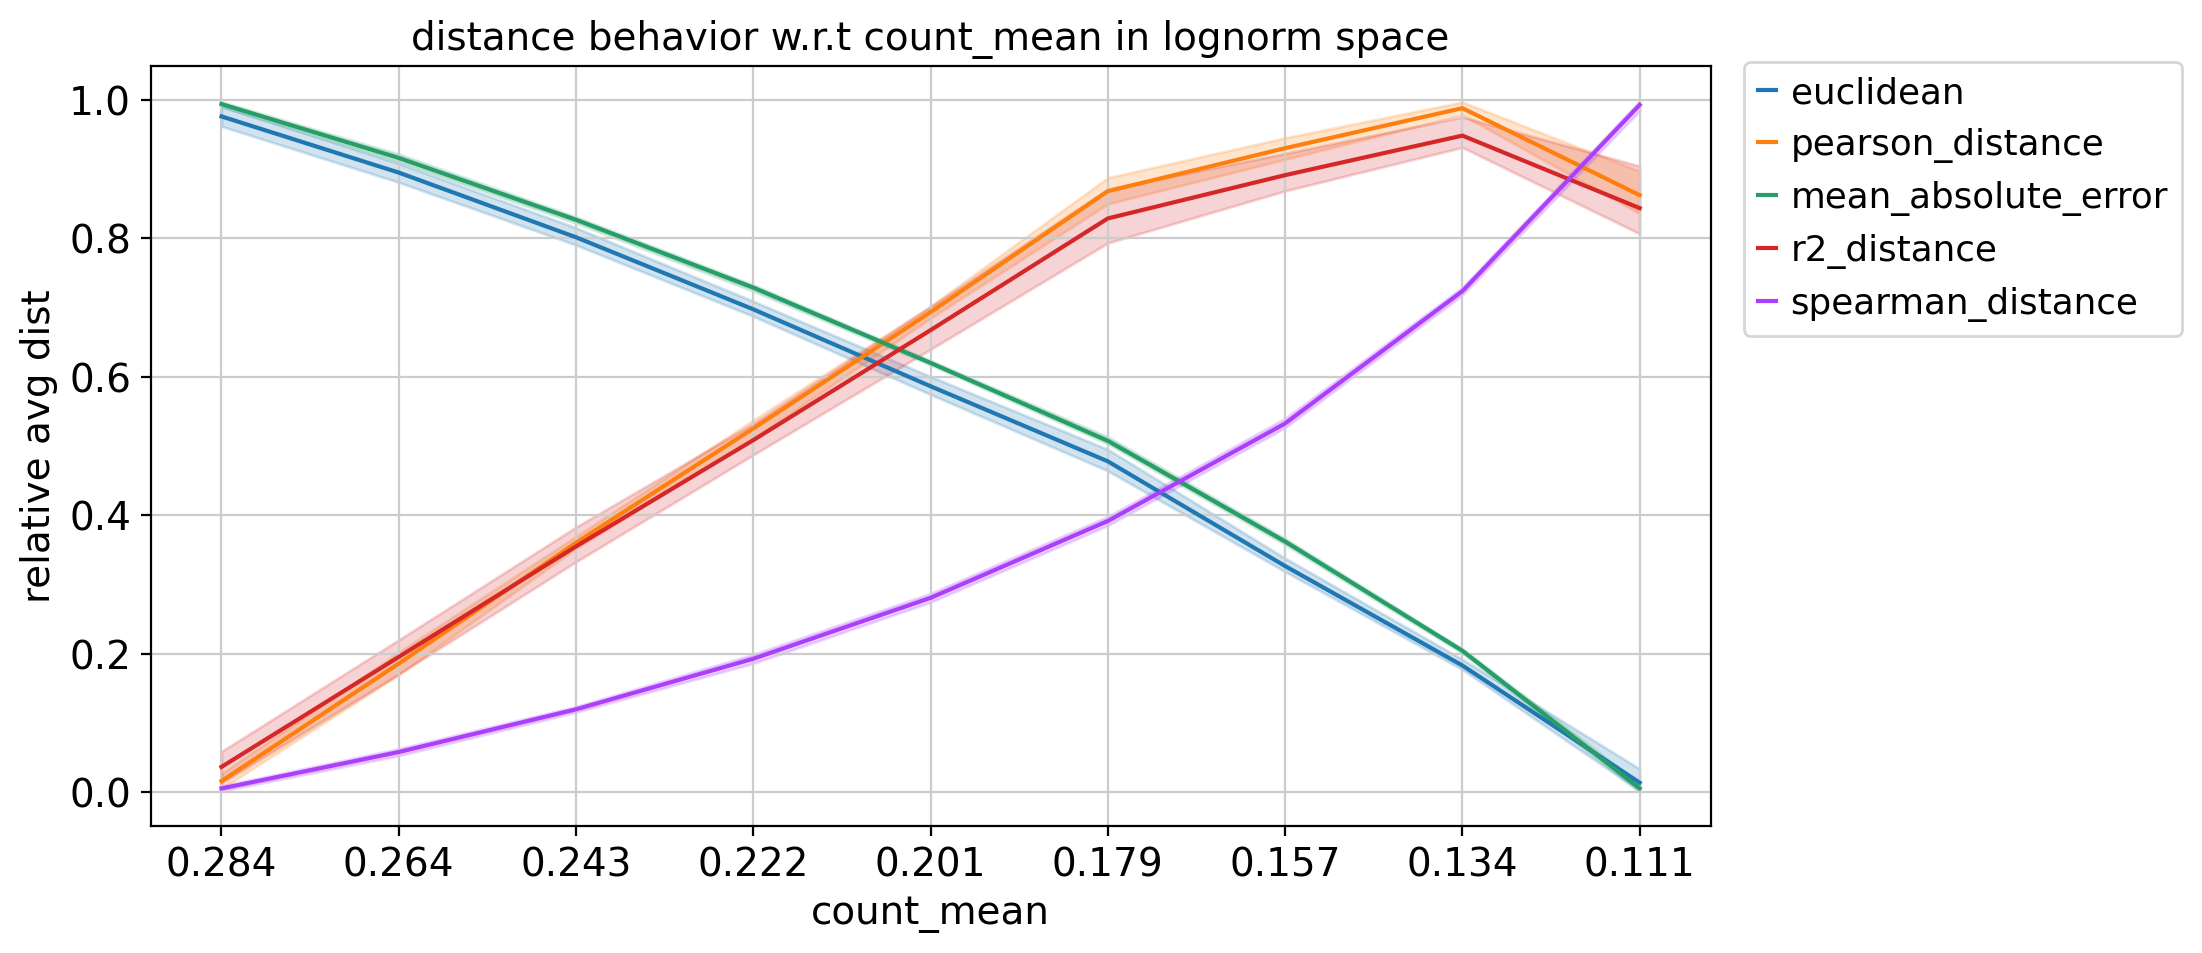

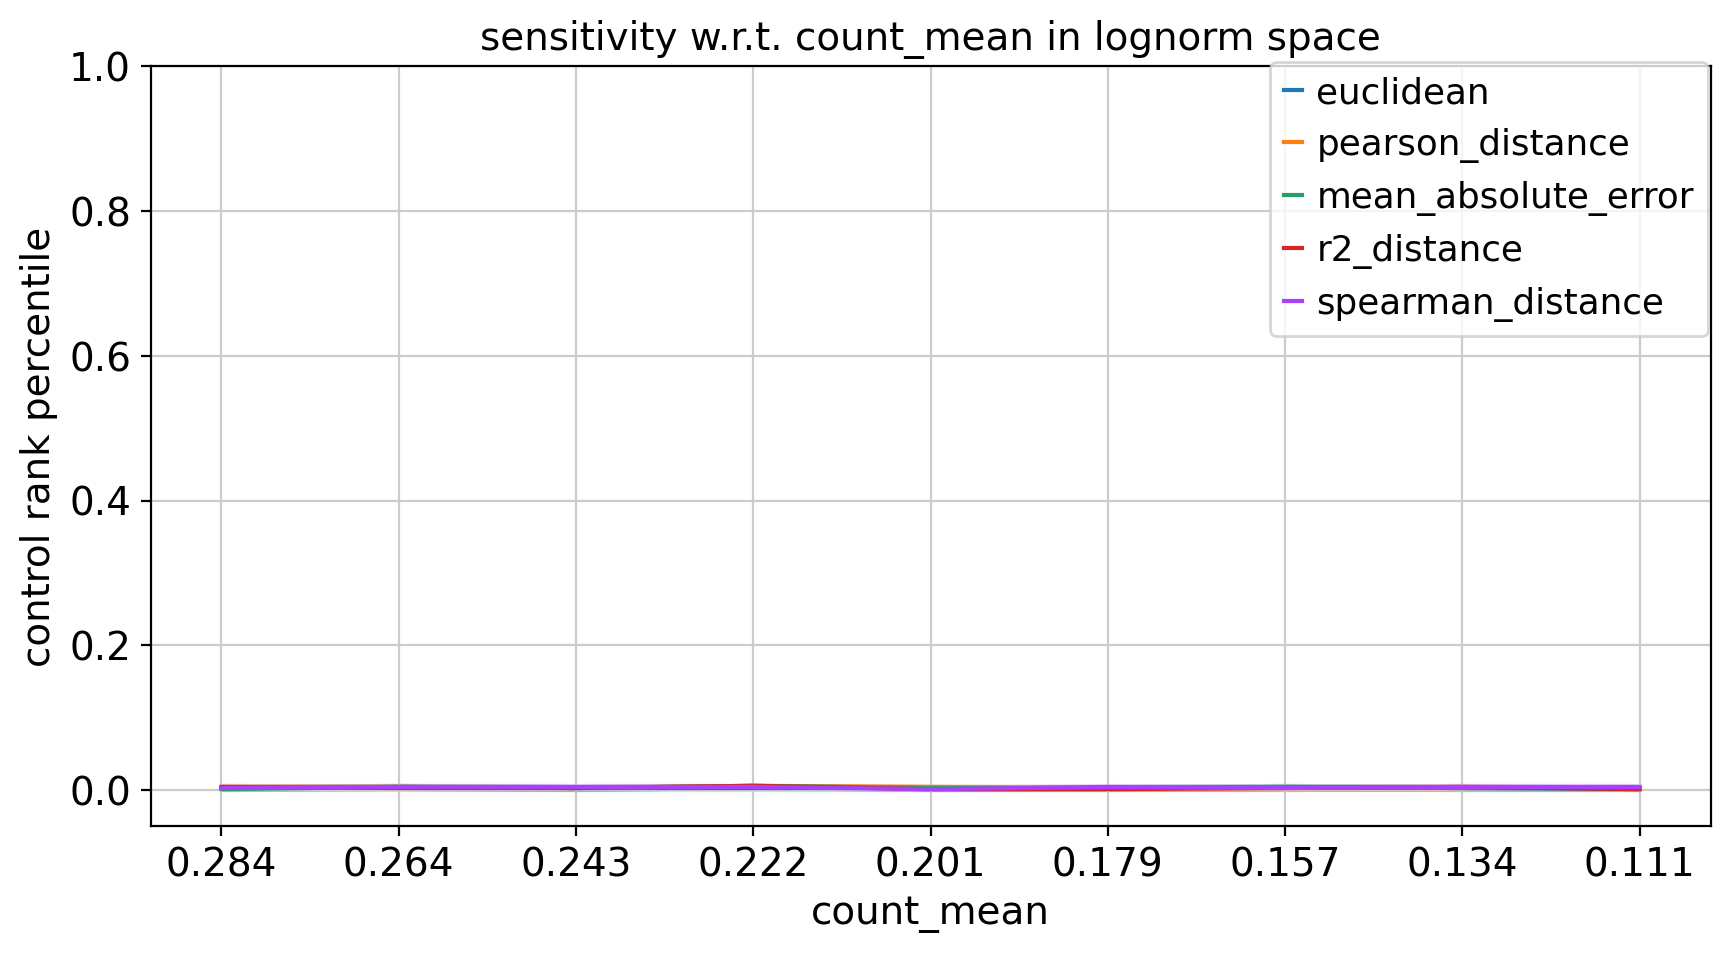

In [18]:
pwdfs = plot(['count_mean', 'lognorm'])

## summary

In [24]:
from utils import get_melted_df_per_perturbation

In [22]:
pwdfs = plot(['n_cells', 'lognorm', '250'], plot=False)

In [28]:
df = get_melted_df_per_perturbation(pwdfs, metrics, controls, 'n_cells', reference='spearman_distance-250')

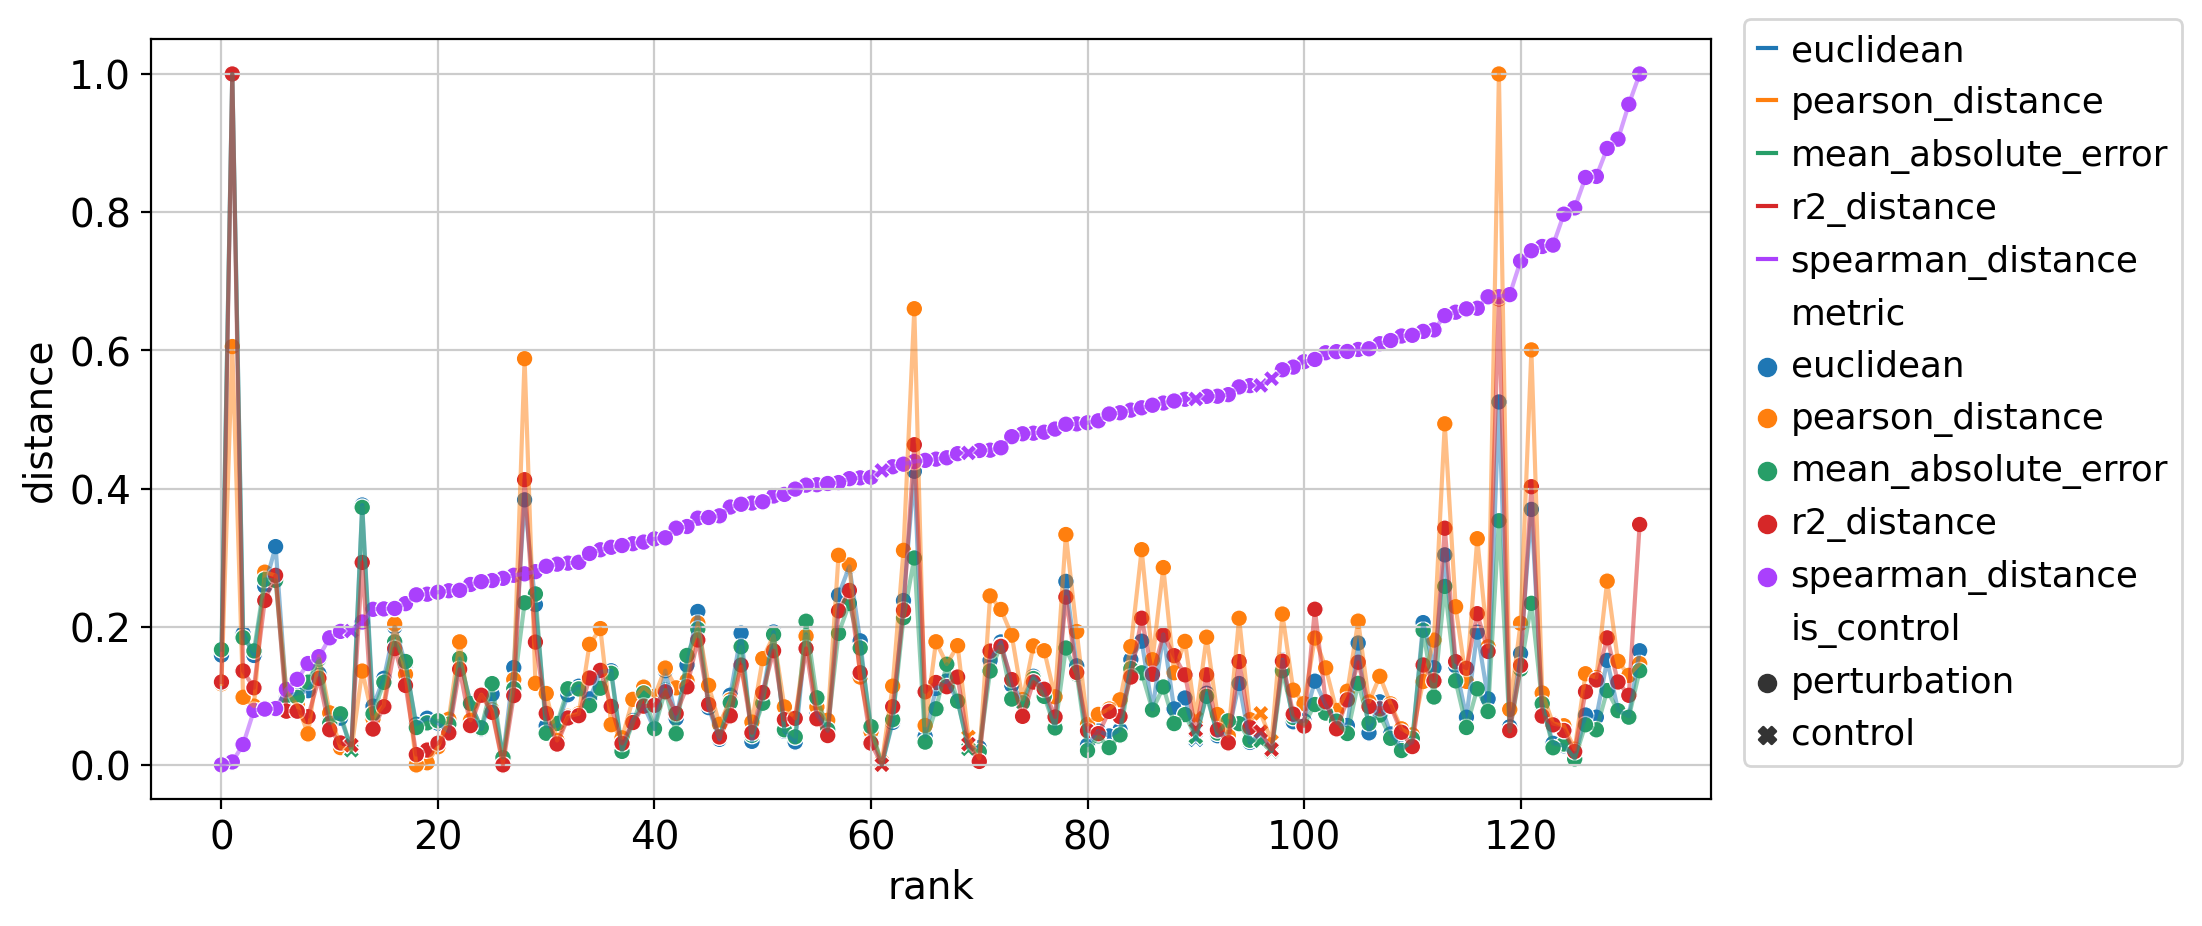

In [29]:
normed_df = normalize_per_metric(df, label='distance')
plt.figure(figsize=(10, 5))
sns.lineplot(data=normed_df, x='rank', y='distance', hue='metric', alpha=.5)
sns.scatterplot(data=normed_df, x='rank', y='distance', hue='metric', style='is_control')
plt.legend(bbox_to_anchor=(1.01, 1.05))

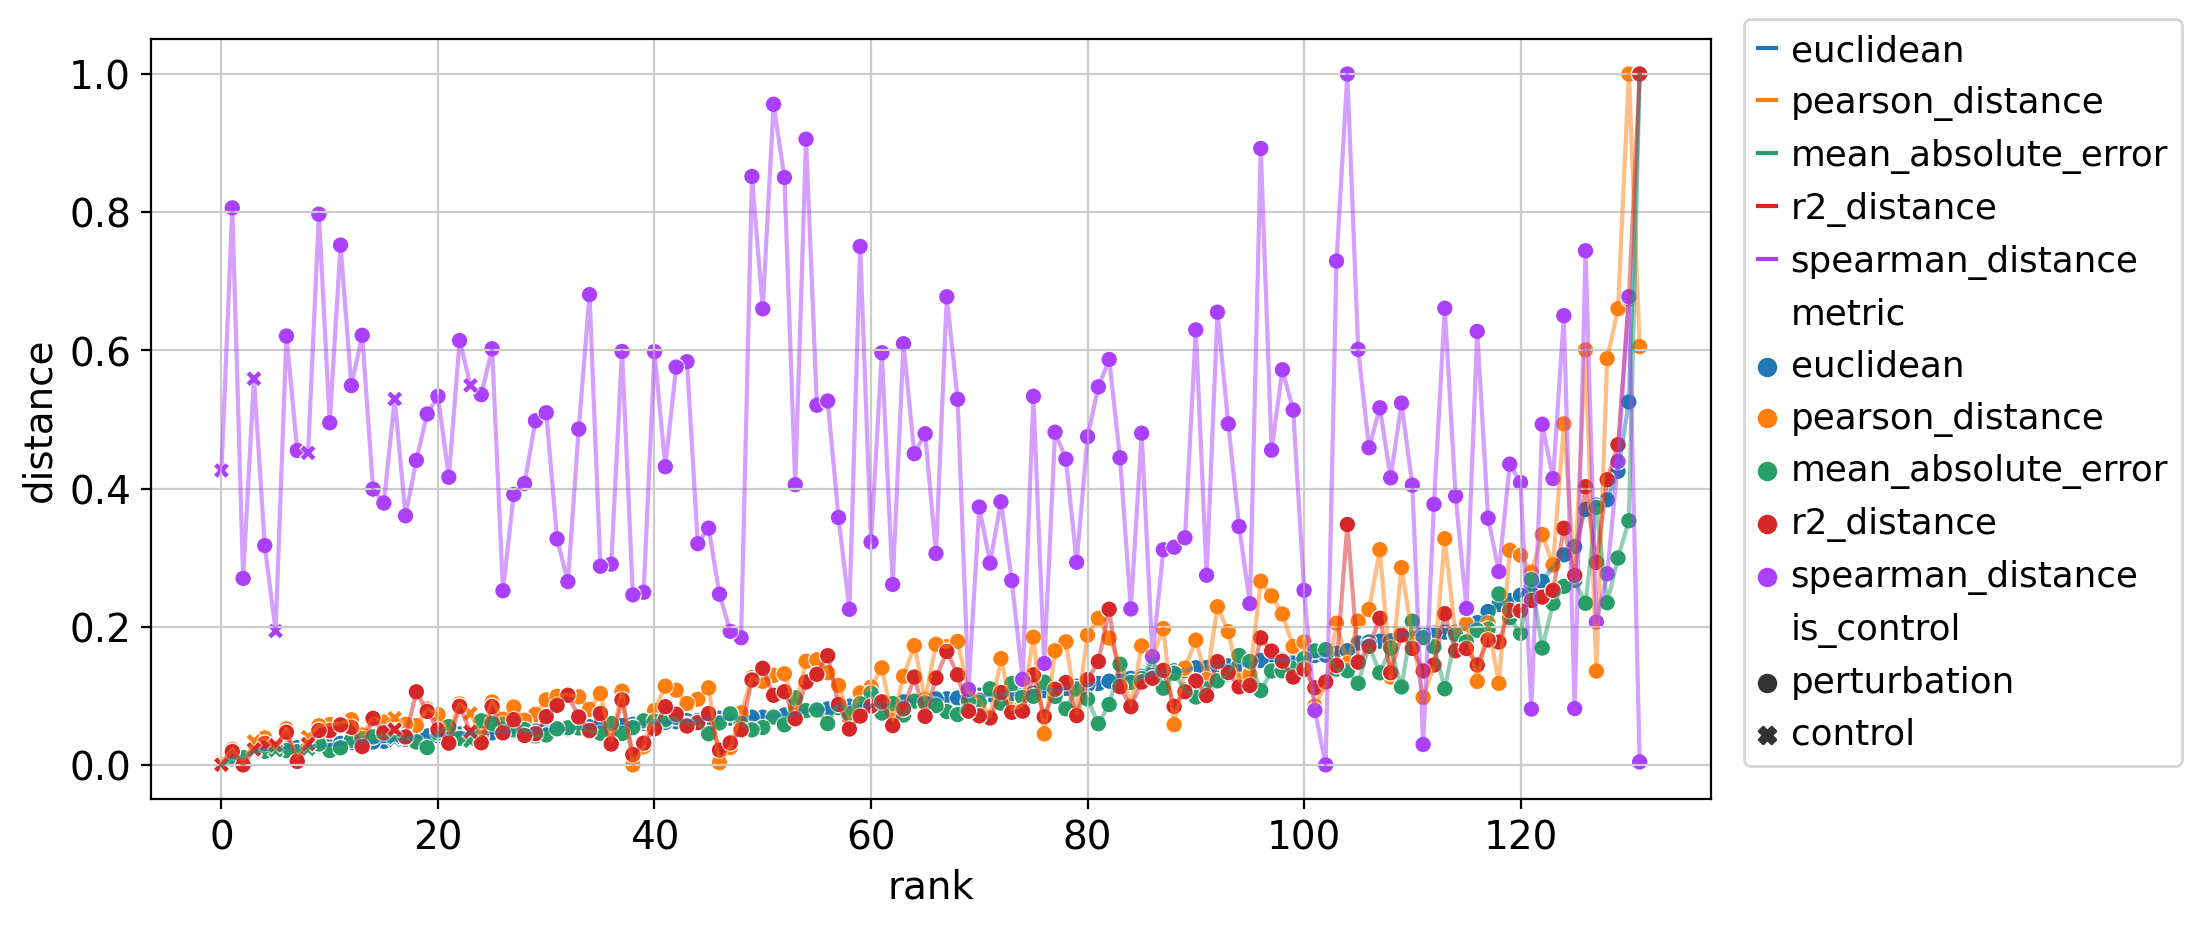

In [27]:
normed_df = normalize_per_metric(df, label='distance')
plt.figure(figsize=(10, 5))
sns.lineplot(data=normed_df, x='rank', y='distance', hue='metric', alpha=.5)
sns.scatterplot(data=normed_df, x='rank', y='distance', hue='metric', style='is_control')
plt.legend(bbox_to_anchor=(1.01, 1.05))

## summary table

### correlation with actual DE factors

Concatenate the _individual_ melted distance dataframes and label with metadata. Calculate and visualize change in distance due to sample size.

In [26]:
# import pertpy as pt

In [27]:
# adata = pt.data.srivatsan_2020_sciplex3()
# adata.obs['perturbation_name'] = adata.obs.perturbation.values
# adata.obs['perturbation'] = adata.obs['perturbation_name'].astype(str) + '_' + adata.obs.dose_value.astype(str)
# adata.obs['perturbation'] = adata.obs['perturbation'].replace({'control_0.0':'control'})

In [ ]:
# adata.obs[['perturbation']]

In [57]:
# # get metadata
# params = pd.read_csv('../splatter_sim_params.csv').reset_index()
# params['perturbation'] = [f'Path{x}' for x in params['index'].values]
# params.perturbation.replace({'Path1': 'control'}, inplace=True)

# def annotate(df, params):
#     # annotate
#     for col in params.columns:
#         df[col] = df['perturbation'].map(dict(zip(params.perturbation, params[col])))
#     df = df.dropna()  # dropping fake controls

In [15]:
import numpy as np
def annotate(df):
    df['dose'] = [0 if 'control' in x else float(x.split('_')[1]) for x in df.perturbation]
    df['log(dose)'] = [0 if 'control' in x else np.log10(float(x.split('_')[1])) for x in df.perturbation]

In [16]:
exp = 'n_genes'
pwdfs, ctrl_ranks = plot([exp, 'lognorm', '2000'], plot=False)
df = get_melted_df_per_perturbation(pwdfs, metrics, controls, exp, reference='wasserstein-2000')
annotate(df)

Plot rankings together:

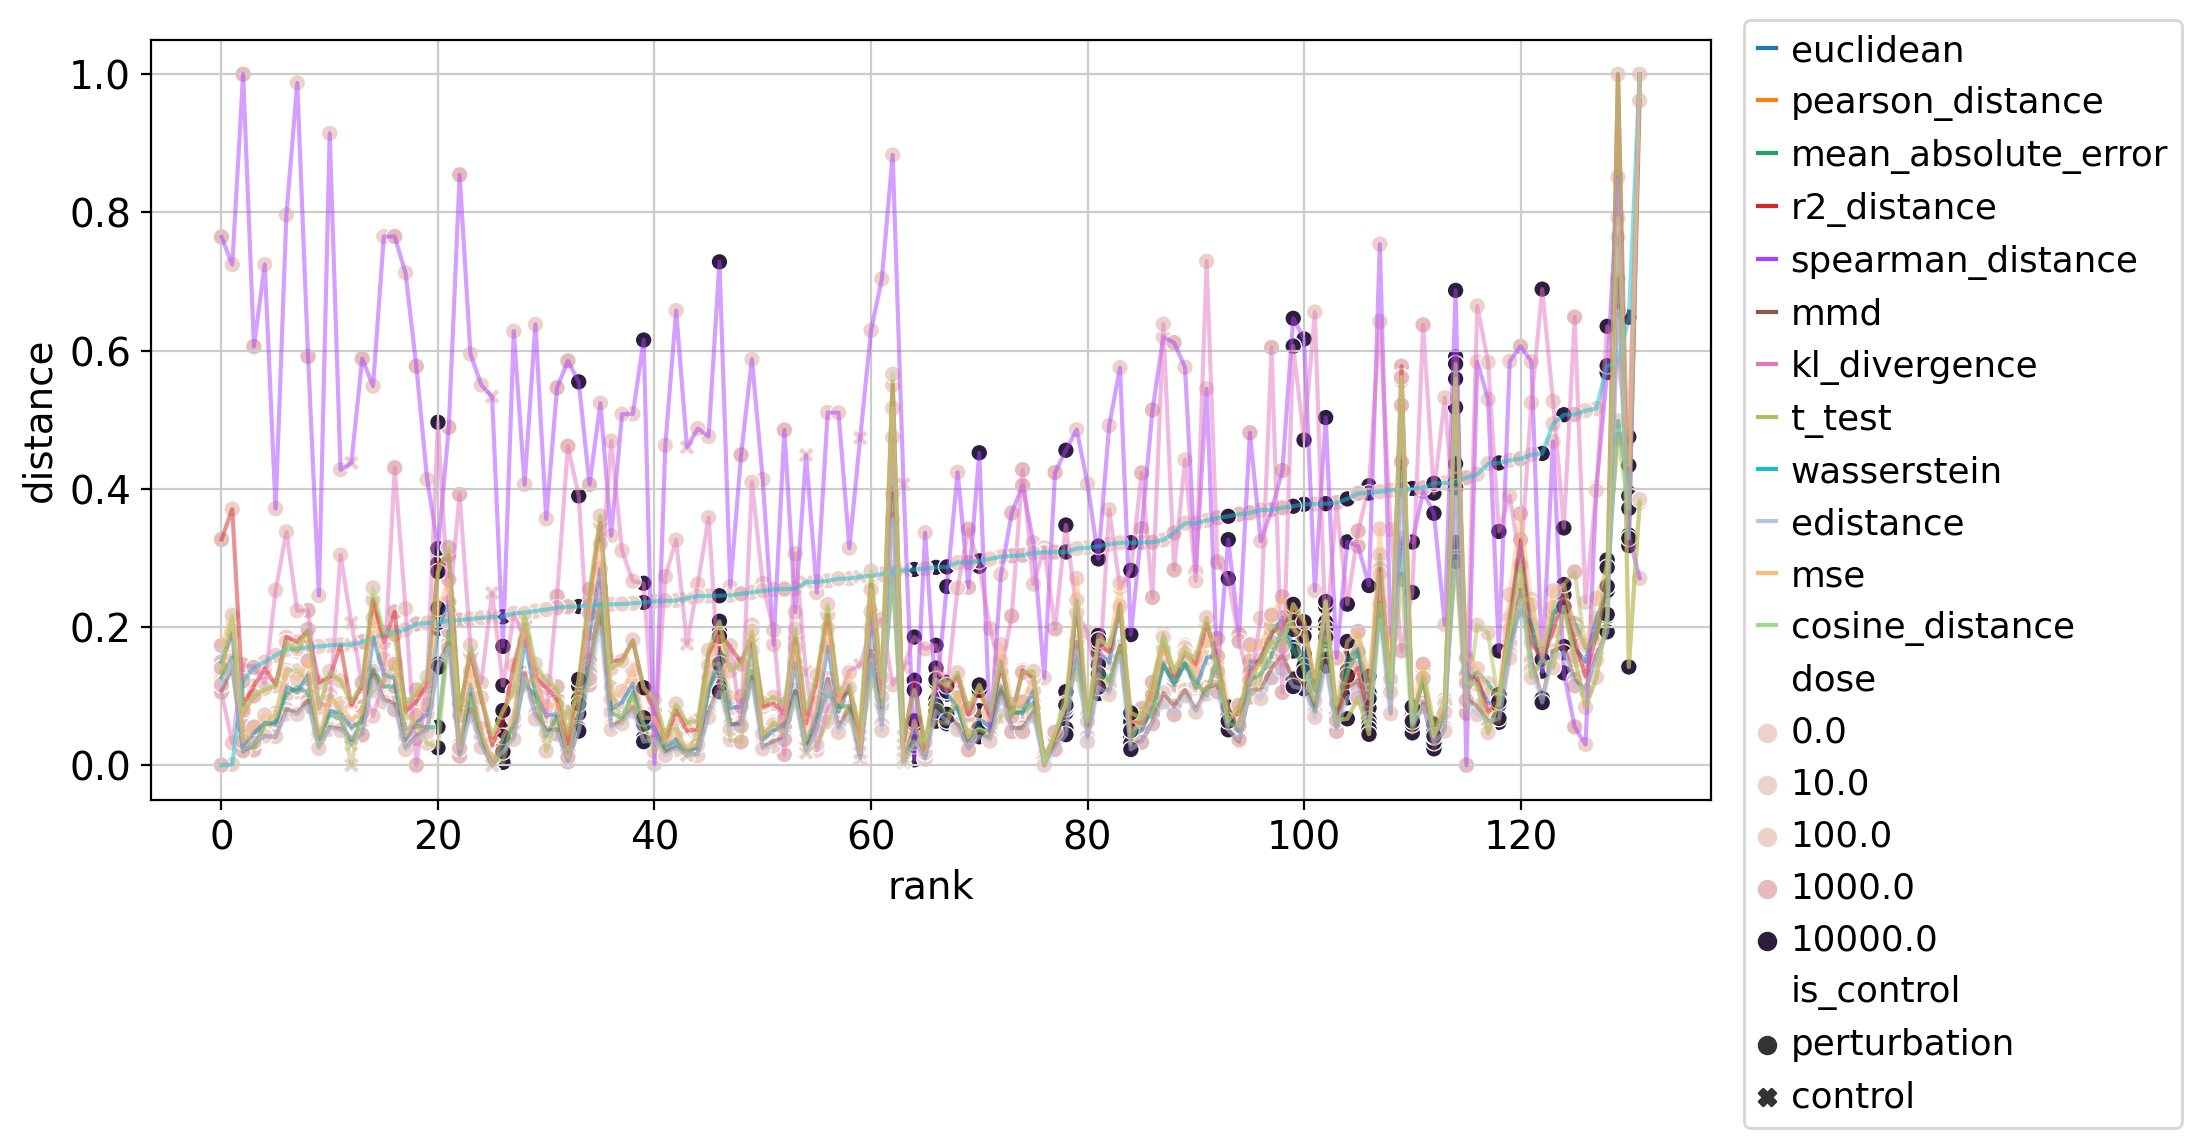

In [17]:
normed_df = normalize_per_metric(df, label='distance')
plt.figure(figsize=(10, 5))
sns.lineplot(data=normed_df, x='rank', y='distance', hue='metric', alpha=.5)
sns.scatterplot(data=normed_df, x='rank', y='distance', hue='dose', style='is_control')
plt.legend(bbox_to_anchor=(1.01, 1.05))

Calculate spearman correlation with dose per metric:

In [18]:
from scipy.stats import spearmanr

In [19]:
df = get_ranked_df_per_perturbation(pwdfs, metrics, controls, exp)
df = df[df.is_control == 'perturbation']
annotate(df)

In [20]:
sr = {}
for m in metrics:
    sub = df[df.metric == m]
    sr[m] = spearmanr(sub['distance'].values, sub.dose.values)[0]
corr_wreal = pd.DataFrame.from_dict(sr, orient='index').sort_values(0)
corr_wreal[0] = 1 - corr_wreal[0]  # flip so smaller is better
corr_wreal.columns = ['1-corr_dose']
corr_wreal

1-corr_dose
spearman_distance       1.177531
cosine_distance         1.102867
pearson_distance        1.098213
r2_distance             1.094036
t_test                  1.039104
mean_absolute_error     1.019046
mmd                     1.018652
euclidean               1.018602
mse                     1.018261
edistance               1.014050
kl_divergence           0.972231
wasserstein             0.809241

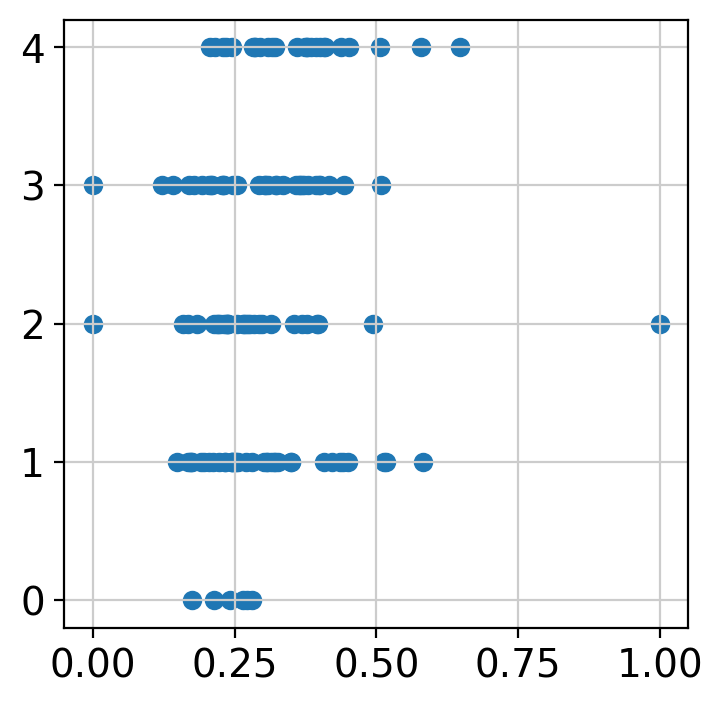

In [31]:
plt.scatter(normed_df[normed_df.metric == 'wasserstein']['distance'], normed_df[normed_df.metric == 'wasserstein']['log(dose)'])

### performance in the most realistic scenario

The most realistic scenario for evaluation is 5k highly variable genes, 300 cells per condition, no mislabeling and optimal library size.

In [21]:
pwdfs, ctrl_ranks = plot([exp, 'lognorm'], plot=False)
best_case = ctrl_ranks[ctrl_ranks[exp] == '2000']

avg_rank = best_case[['rank', 'metric']].groupby('metric').mean().sort_values('rank')
avg_rank.columns = ['rank_mean']

var_rank = best_case[['rank', 'metric']].groupby('metric').var().sort_values('rank')*100
var_rank.columns = ['rank_var*100']

### summary

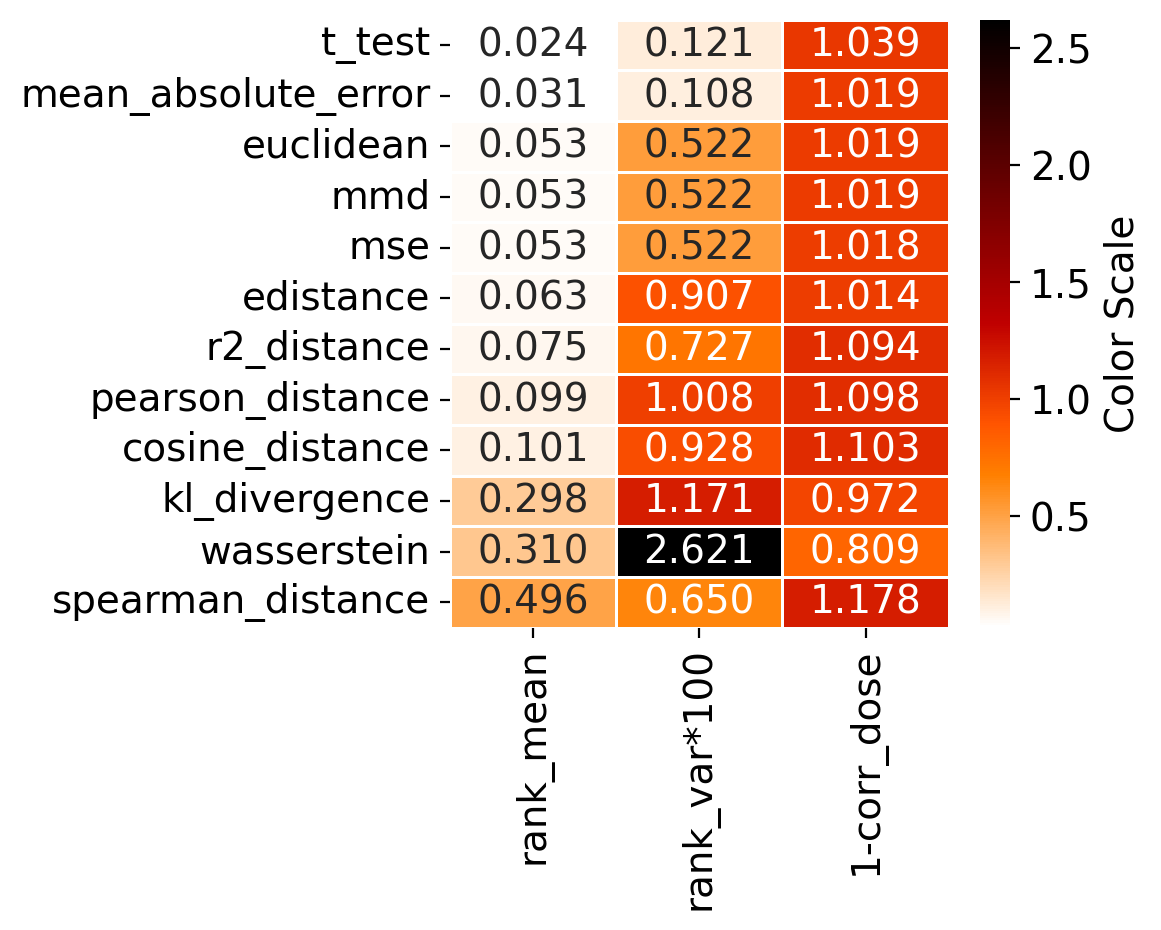

In [22]:
df = pd.concat([avg_rank, var_rank, corr_wreal], axis=1)
# df = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis=0)
sns.heatmap(df, annot=True, cmap='gist_heat_r', fmt=".3f", linewidths=.5, cbar_kws={'label': 'Color Scale'})
plt.grid(None)

In [23]:
df

rank_mean  rank_var*100  1-corr_dose
t_test                0.024427      0.120622     1.039104
mean_absolute_error   0.030534      0.107803     1.019046
euclidean             0.053435      0.521531     1.018602
mmd                   0.053435      0.521531     1.018652
mse                   0.053435      0.521531     1.018261
edistance             0.062595      0.907290     1.014050
r2_distance           0.074809      0.726648     1.094036
pearson_distance      0.099237      1.008100     1.098213
cosine_distance       0.100763      0.927685     1.102867
kl_divergence         0.297710      1.171260     0.972231
wasserstein           0.309924      2.621059     0.809241
spearman_distance     0.496183      0.649729     1.177531

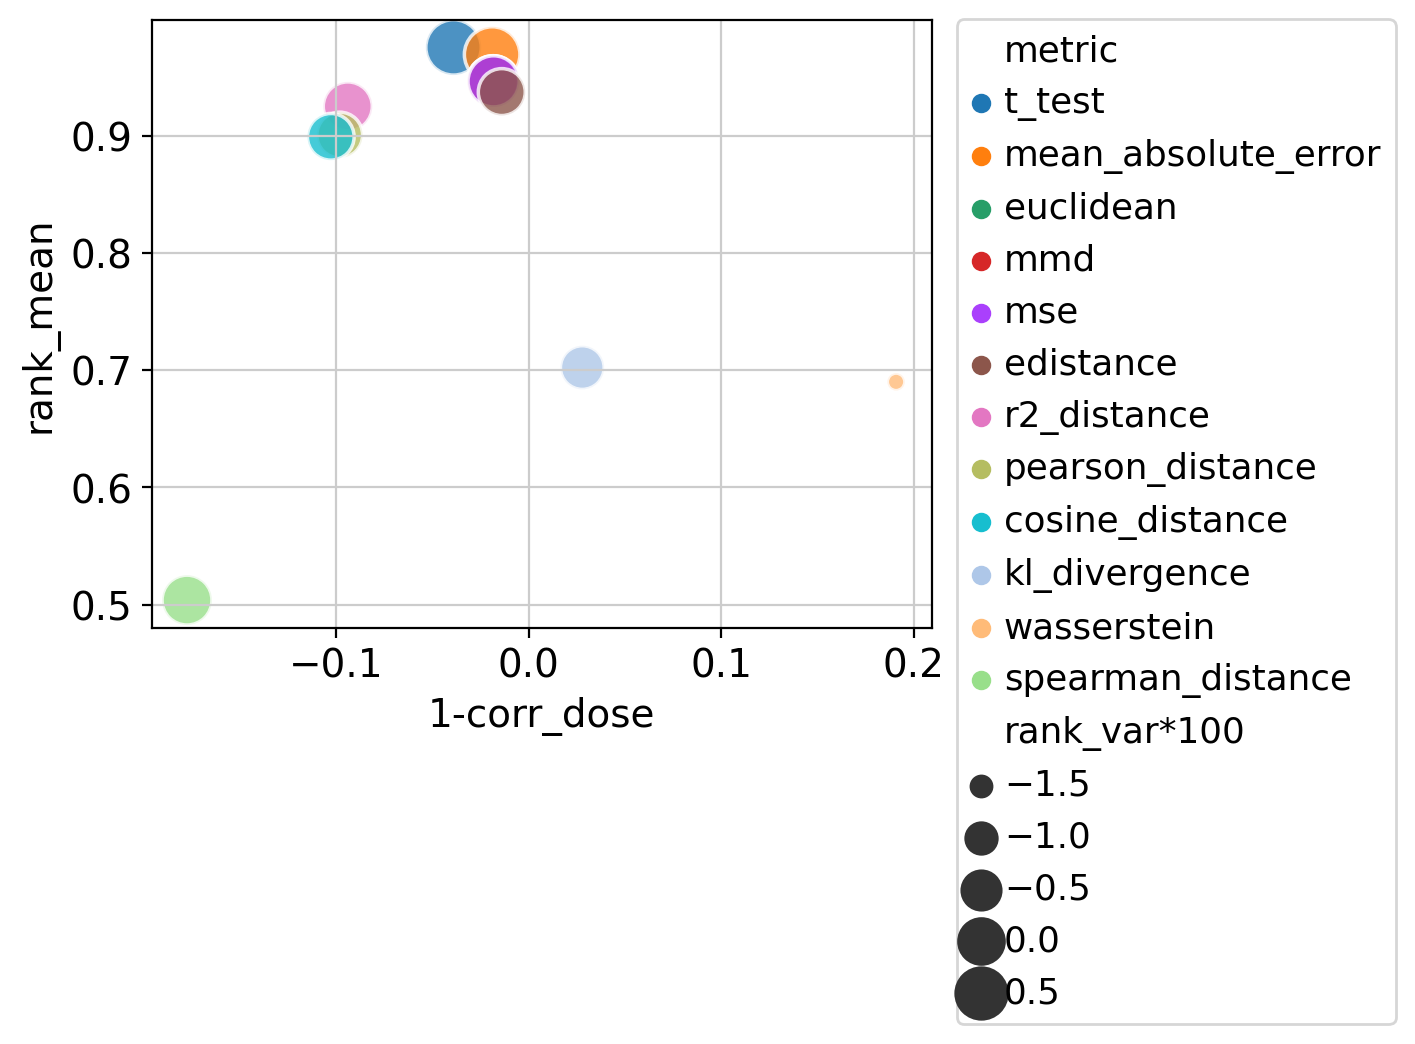

In [28]:
plt.figure(figsize=(5, 4))
new_df = 1-df
sns.scatterplot(
    new_df.reset_index().rename(columns={'index':'metric'}),
    y='rank_mean', x='1-corr_dose', hue='metric', size='rank_var*100',
    sizes=(40, 400), alpha=.8)
plt_legend()

## between metric correlation

In [62]:
pwdfs, ctrl_ranks = plot([exp, 'lognorm'], plot=False)
df = pd.concat([pwdfs[f'{metric}-2000'].loc[['control0']] for metric in metrics]).T
df.columns = metrics
df = df.reset_index()
annotate(df)
df = df.dropna()

In [63]:
def corr_plot(col1, col2, **kwargs):
    sns.scatterplot(data=df, x=col1, y=col2, **kwargs)
    corr = spearmanr(df[col1].values, df[col2].values)[0]
    plt.title(f'corr={corr:.3f}')
    plt.xscale('log')
    plt.yscale('log')
    plt_legend()

In [61]:
df.corr(method='spearman')

kl_divergence  euclidean    t_test  spearman_distance  \
kl_divergence             1.000000   0.235141  0.521080           0.320840   
euclidean                 0.235141   1.000000  0.774169           0.116991   
t_test                    0.521080   0.774169  1.000000           0.390397   
spearman_distance         0.320840   0.116991  0.390397           1.000000   
wasserstein               0.468249   0.457562  0.515668          -0.210538   
pearson_distance          0.145828   0.886276  0.610153           0.206368   
edistance                 0.223557   0.993605  0.764448           0.104084   
r2_distance               0.152677   0.909219  0.653211           0.217936   
cosine_distance           0.142529   0.885235  0.610756           0.209774   
mmd                       0.235141   1.000000  0.774169           0.116991   
mean_absolute_error       0.308285   0.934933  0.886345           0.118918   
mse                       0.235141   1.000000  0.774169           0.116991   
dose                      0.057904   0.059167  0.104713          -0.051267   
log(dose)                 0.057904   0.059167  0.104713          -0.051267   

                     wasserstein  pearson_distance  edistance  r2_distance  \
kl_divergence           0.468249          0.145828   0.223557     0.152677   
euclidean               0.457562          0.886276   0.993605     0.909219   
t_test                  0.515668          0.610153   0.764448     0.653211   
spearman_distance      -0.210538          0.206368   0.104084     0.217936   
wasserstein             1.000000          0.180772   0.452282     0.173774   
pearson_distance        0.180772          1.000000   0.873656     0.941563   
edistance               0.452282          0.873656   1.000000     0.907420   
r2_distance             0.173774          0.941563   0.907420     1.000000   
cosine_distance         0.174825          0.999717   0.873202     0.942962   
mmd                     0.457562          0.886276   0.993605     0.909219   
mean_absolute_error     0.570918          0.765579   0.929883     0.799568   
mse                     0.457562          0.886276   0.993605     0.909219   
dose                    0.220893         -0.009016   0.070920    -0.015375   
log(dose)               0.220893         -0.009016   0.070920    -0.015375   

                     cosine_distance       mmd  mean_absolute_error       mse  \
kl_divergence               0.142529  0.235141             0.308285  0.235141   
euclidean                   0.885235  1.000000             0.934933  1.000000   
t_test                      0.610756  0.774169             0.886345  0.774169   
spearman_distance           0.209774  0.116991             0.118918  0.116991   
wasserstein                 0.174825  0.457562             0.570918  0.457562   
pearson_distance            0.999717  0.886276             0.765579  0.886276   
edistance                   0.873202  0.993605             0.929883  0.993605   
r2_distance                 0.942962  0.909219             0.799568  0.909219   
cosine_distance             1.000000  0.885235             0.765152  0.885235   
mmd                         0.885235  1.000000             0.934933  1.000000   
mean_absolute_error         0.765152  0.934933             1.000000  0.934933   
mse                         0.885235  1.000000             0.934933  1.000000   
dose                       -0.012240  0.059167             0.093697  0.059167   
log(dose)                  -0.012240  0.059167             0.093697  0.059167   

                         dose  log(dose)  
kl_divergence        0.057904   0.057904  
euclidean            0.059167   0.059167  
t_test               0.104713   0.104713  
spearman_distance   -0.051267  -0.051267  
wasserstein          0.220893   0.220893  
pearson_distance    -0.009016  -0.009016  
edistance            0.070920   0.070920  
r2_distance         -0.015375  -0.015375  
cosine_distance     -0.012240  -0.012240  
mmd                  0.059167   0

Correlation between winners and runner ups:

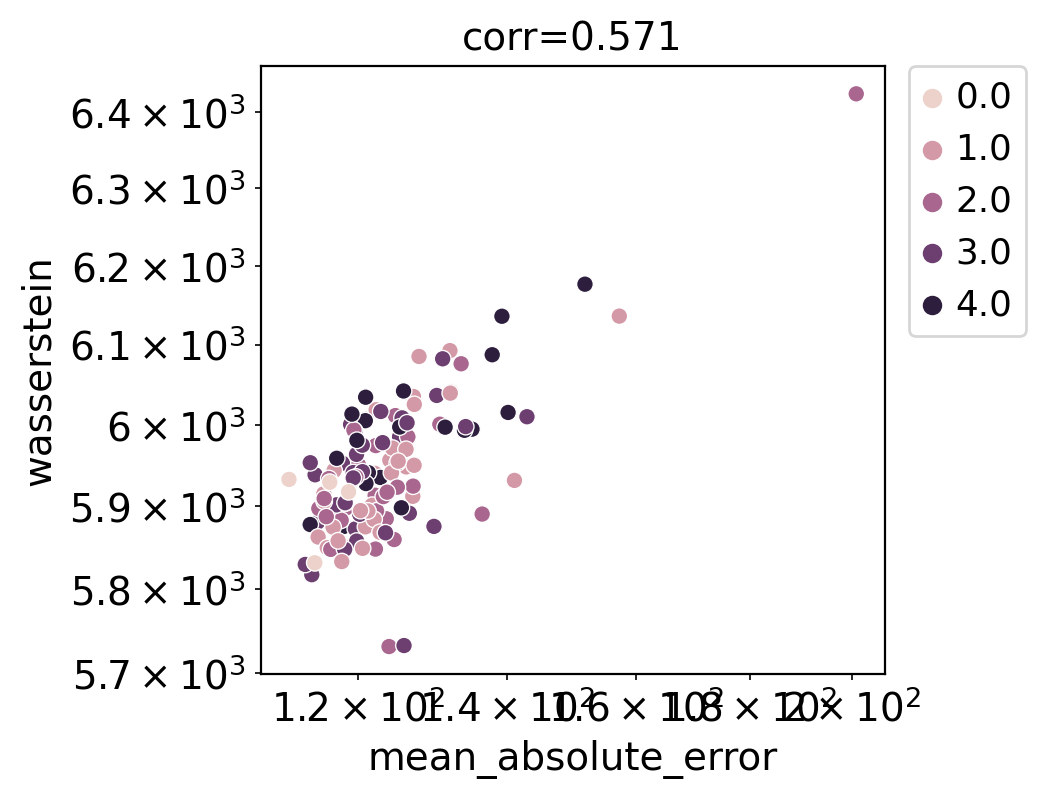

In [64]:
corr_plot('mean_absolute_error', 'wasserstein', hue='log(dose)')